# Imports\


TODO:
1) check value/vat/no vat
2) check headlines, fix it


In [1]:
# !export GPN_DB_HOST=192.168.10.36


In [2]:
#!ls -la ../../work
# #!mv ../../../documents.json.zip ../../work
# # !unzip '../../work/documents.json.zip' '../../work/documents.json'
# !mv documents.json ../../work

In [3]:
IMPORT_FRESH_ONLY = True # re-import all if False

In [4]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print("tf",tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')



2023-02-08 16:31:48.659332: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
DEBUG - 2023-02-08 16:31:49,299 - retrain_ipynb - --=logging started=--


tf 2.5.0
Running on CPU:x86_64


In [5]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
import analyser.hyperparams 

Nemoware Analyser v23.2.7
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')



### Imports...

In [6]:
%matplotlib inline

import pandas as pd
import numpy as np
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection

from datetime import datetime
from math import log1p
from pandas import DataFrame
from analyser.persistence import DbJsonDoc
from colab_support.renderer import plot_embedding

from analyser.structures import DocumentState

from pathlib import Path
from bson import ObjectId

from datetime import date
from dateutil.relativedelta import relativedelta


from pymongo import ASCENDING

# from tf_support.super_contract_model import seq_labels_contract, seq_labels_contract_swap_orgs
# 


[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None
[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


### Prepare workdir

In [7]:
_work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

analyser.hyperparams.work_dir = work_dir
 

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /root/artem/work


### Query DB for contact IDs

#### Load meta data CSV

In [8]:
!touch /root/artem/work/contract_trainset_meta.temp.csv

In [9]:
# stats[["user_correction_date", 'analyze_date']].max().max()

In [10]:
export_fn = str(Path(work_dir) / 'contract_trainset_meta.temp.csv')
# stats = pd.read_csv(export_fn, index_col=0)

try:
    stats = pd.read_csv(export_fn, index_col=0)
    if not 'analyze_date' in stats:
        stats['analyze_date'] = None
        
    if not 'documentType' in stats:
        stats['documentType'] = 'Unknown'
    
    stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=True)
    stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=True)

    lastdate = stats[["user_correction_date", 'analyze_date']].max().max()
    
except Exception as ex:
    print(f'ERROR: cannot load {export_fn}')
    logger.exception(ex)
    logger.error(f'cannot load {export_fn}')

    lastdate = datetime(1900, 1, 1)
    stats = DataFrame()
    
    
if not IMPORT_FRESH_ONLY:
    lastdate = datetime(1900, 1, 1)
    
print(f'lastdate={lastdate} ; export_fn={export_fn}')
stats['source'] = 'db'
stats

lastdate=2023-02-07 17:29:24.606000+00:00 ; export_fn=/root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-07 17:45:38.069131,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,ГПН,SUN,SUN,Service,1.000000,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,Покупатель,Иідате. тьско-ііо. тиі рафнческое предприятие ...,Поставщик,Deal,1.000000,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,Арендатор,"Фонд исследований, инноваций, инвестиций Тюмен...",Арендодатель,Renting,1.000000,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,Принципал,Газпромнефть-Снабжение,Агент,AgencyContract,1.000000,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,Агент,ГазРромнефть-ГЕО,Принципал,AgencyContract,1.000000,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63c506bfe2456d59975e1147,db,c590c097f5dcc8b350ffee512aed14c6,23.2.7,2023-02-07 17:45:53.746461,5612.0,2023-02-07 17:29:21.525000+00:00,12.0,2.564949,2246.0,RUB,...,Заказчик,Рога и копыта,Исполнитель,Service,0.999992,NaT,True,CONTRACT,70.0,15.0
63c506b9e2456d59975e10af,db,7316ad5f69f3c35f2c03aa23331bb9e2,23.2.7,2023-02-07 17:45:53.846874,11369.0,2023-02-07 17:29:22.453000+00:00,NaN,NaN,NaN,NaN,...,ГАРАНТ,NaN,ПРИНЦИПАЛ,BankGuarantees,0.978081,NaT,True,CONTRACT,10.0,16.0
63c506b9e2456d59975e10b3,db,0c028edaf60667d38b29a12999772a0a,23.2.7,2023-02-07 17:45:53.900689,8266.0,2023-02-07 17:29:23.164000+00:00,142956000.0,18.778047,1033.0,RUB,...,Заказчик,Газпромнефть НТЦ,Исполнитель,Service,1.000000,NaT,True,CONTRACT,55.0,40.0
63c506aee2456d59975e0fc5,db,e1d782e9e5ce6e55863b7f53ced83e51,23.2.7,2023-02-07 17:45:53.947591,2250.0,2023-02-07 17:29:23.999000+00:00,NaN,NaN,NaN,NaN,...,ЗАКАЗЧИК,РОСА,ИСПОЛНИТЕЛЬ,Service,0.955178,NaT,True,CONTRACT,32.0,20.0


# functions

In [11]:

def get_amount(attr_tree):
  _value_tag = attr_tree.get('price')
  amount = None
  if _value_tag is not None:
    amount = _value_tag.get('amount_netto')
    if amount is None:
      amount = _value_tag.get('amount_brutto')
    if amount is None:
      amount = _value_tag.get('amount')
  return amount

        
    
def add_stats_record(d: DbJsonDoc, stats: DataFrame, source='db'):
  _id = str(d.get_id())
    
  attr_tree = d.get_attributes_tree()
 

  stats.at[_id, 'checksum'] = d.get_tokens_for_embedding().get_checksum()
  stats.at[_id, 'version'] = d.get_version_string()
  stats.at[_id, 'documentType'] = d.documentType
    
 
  stats.at[_id, 'source'] = source
  stats.at[_id, 'export_date'] = datetime.now()
  stats.at[_id, 'len'] = len(d)
  stats.at[_id, 'analyze_date'] = pd.to_datetime( d.analysis['analyze_timestamp'] , utc=True)


  n_headers = len(d.analysis.get('headers', []))
  stats.at[_id, 'headers'] = n_headers
    
  _value_tag = attr_tree.get('price')
  
  if _value_tag is not None:
    amount = get_amount(attr_tree) 
    if amount:
        
        stats.at[_id, 'value'] = amount.get('value') 
        stats.at[_id, 'value_log1p'] = log1p(amount.get('value') )
        stats.at[_id, 'value_span'] = amount.get('span', [0,0]) [0]
#         print( stats.at[_id, 'value'])
    
    stats.at[_id, 'currency'] = _value_tag.get('currency', {}).get('value')
  
  _orgs = attr_tree.get('orgs', [{},{}]) 
  if len(_orgs)>0:
      stats.at[_id, 'org-1-name'] = _orgs[0].get('name', {}).get('value')
      stats.at[_id, 'org-1-alias'] = _orgs[0].get('alias', {}).get('value')

      if len(_orgs)>1:
        stats.at[_id, 'org-2-name'] = _orgs[1].get('name', {}).get('value')
        stats.at[_id, 'org-2-alias'] = _orgs[1].get('alias', {}).get('value')

  stats.at[_id, 'subject'] = attr_tree.get('subject', {}).get('value')
  stats.at[_id, 'subject confidence'] = attr_tree.get('subject', {}).get('confidence')
    

  span = attr_tree.get('subject', {}).get('span',[0,0])
  subject_len = span[1] - span[0]
  stats.at[_id, 'subj_len'] = subject_len  

  if d.user is not None:
    # if 'attributes_tree' in d.user and 'creation_date' in d.user['attributes_tree']:
    # stats.at[_id, 'user_correction_date'] = d.user['attributes_tree']['creation_date']
    stats.at[_id, 'user_correction_date'] = pd.to_datetime(d.user[ 'updateDate'], utc=True)
    

    # find_in_dict('attributes_tree.creation_date', d.user)

  valid_state = (DocumentState.Excluded.value==d.state or DocumentState.Done.value==d.state)
  if not valid_state:
    print(_id, 'invalid state: ', d.state)
  valid_struct = ('contract' in jd.analysis['attributes_tree'])
  if not valid_struct:
    print(_id, 'invalid structure: ', d.state)
  stats.at[_id, 'valid'] = valid_state and valid_struct and subject_len>0 and subject_len<=300 and n_headers>0


  


d = get_doc_by_id(ObjectId('5fe34f62b770574a005553be'))
jd = DbJsonDoc(d)
add_stats_record(jd, stats)
stats.loc['5fe34f62b770574a005553be']

DB HOST IS: 192.168.10.36


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_USER environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PASSWORD environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_USE_MONGO_TLS environment variable! defaulting to False
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_CA environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_KEY environment varia

source                                                db
checksum                da2dd54cdcc5b4480207c9def7741d14
version                                           2.3.13
export_date                   2023-02-08 16:31:51.775180
len                                                  759
analyze_date            2020-12-23 17:14:16.727000+00:00
value                                           1.64e+06
value_log1p                                      14.3102
value_span                                           128
currency                                             RUB
org-1-name                        Газпромнефть-Снабжение
org-1-alias                               Благотворитель
org-2-name                           инициатив «Эпсилон»
org-2-alias                              Благополучатель
subject                                          Charity
subject confidence                                     1
user_correction_date    2022-12-08 19:07:01.522000+00:00
valid                          

# load old json

In [12]:
import json
import re
from bson import json_util

_DEBUG = False
file_data=None

try:
    fn = work_dir / 'documents.json'
    with open(fn) as file:
        file_data = json.load(file, object_hook=json_util.object_hook)

        print(f'total docs in {fn} is {len(file_data)}')    
        _DEBUG = True
except Exception as ex:
    logger.exception(ex)    




if _DEBUG:
    a_doc_from_json=DbJsonDoc(file_data[3])

    print(a_doc_from_json.get_attributes_tree())
    print(a_doc_from_json.get_version_string())

total docs in /root/artem/work/documents.json is 622
{'orgs': [{'type': {'span': [47, 48], 'span_map': 'words', 'confidence': 0.49801500000000004, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [49, 50], 'span_map': 'words', 'confidence': 0.9755, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [56, 57], 'span_map': 'words', 'confidence': 0.972, 'value': 'Арендатор'}}, {'type': {'span': [17, 18], 'span_map': 'words', 'confidence': 0.505665, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9905, 'value': 'ЭКРУСС'}, 'alias': {'span': [26, 27], 'span_map': 'words', 'confidence': 0.987, 'value': 'Арендодатель'}}], 'date': {'span': [9, 14], 'span_map': 'words', 'confidence': 1, 'value': datetime.datetime(2016, 5, 10, 0, 0, tzinfo=<bson.tz_util.FixedOffset object at 0x7ff5eba58220>)}, 'number': {'span': [1, 4], 'span_map': 'words', 'confidence': 1, 'value': 'RP 16-06'}, 'subject': {'span': [100, 1

semantic_map_keys ['amount_brutto', 'amount_netto', 'vat', 'sign', 'currency', 'vat_unit']
semantic_map_keys ['org-name', 'org-alias', 'org-type']
semantic_map_keys all ['headline', 'subject', 'date', 'number', 'org-name', 'org-alias', 'org-type', 'amount', 'amount_brutto', 'amount_netto', 'vat', 'sign', 'currency', 'vat_unit', 'value']
semantic_map_keys_contract ['headline-begin', 'headline-end', 'subject-begin', 'subject-end', 'date-begin', 'date-end', 'number-begin', 'number-end', 'org-name-begin', 'org-name-end', 'org-alias-begin', 'org-alias-end', 'org-type-begin', 'org-type-end', 'amount-begin', 'amount-end', 'amount_brutto-begin', 'amount_brutto-end', 'amount_netto-begin', 'amount_netto-end', 'vat-begin', 'vat-end', 'sign-begin', 'sign-end', 'currency-begin', 'currency-end', 'vat_unit-begin', 'vat_unit-end', 'value-begin', 'value-end']


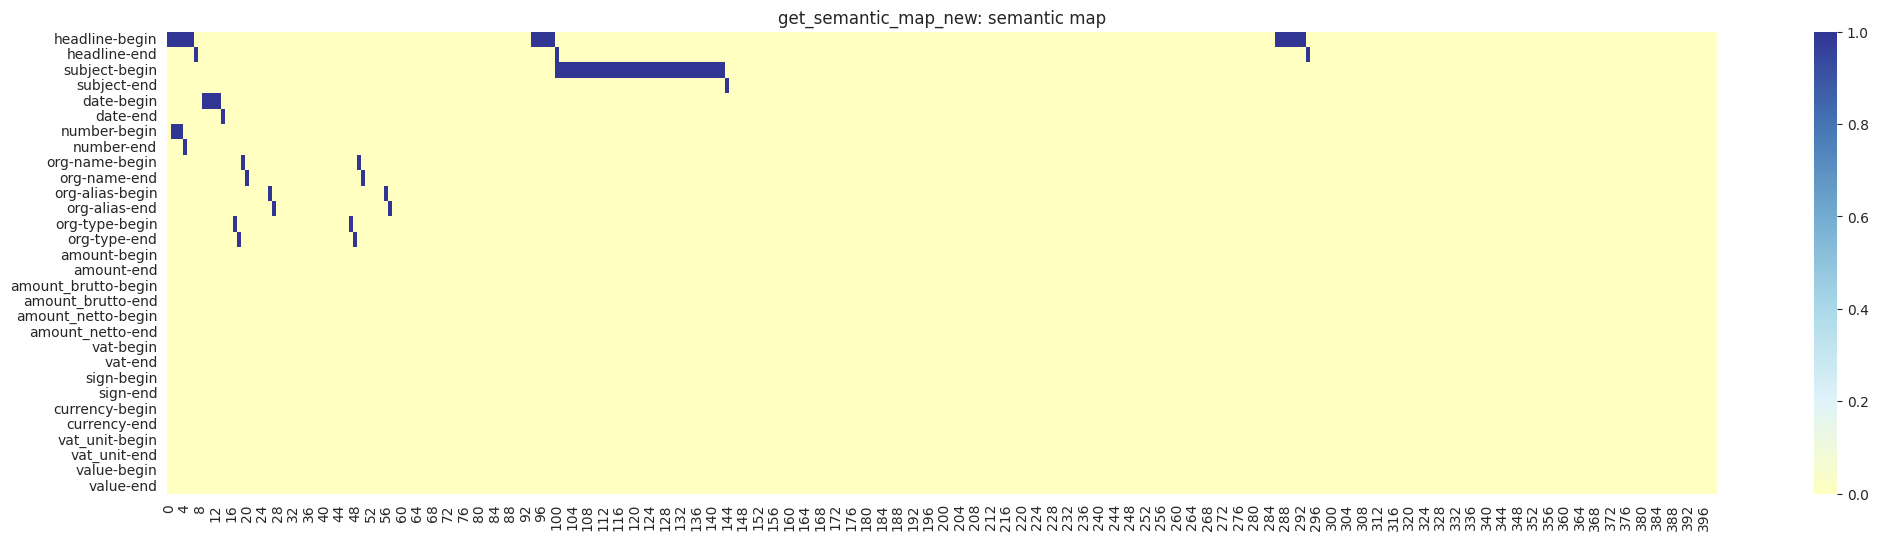

1.0
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3148    0.0
3149    0.0
3150    0.0
3151    0.0
3152    0.0
Name: date-begin, Length: 3153, dtype: float64


In [13]:


semantic_map_keys = [
    'headline',
    'subject', 
    'date', 
    'number',
    'org-name', 
    'org-alias', 
    'org-type'
]

semantic_map_keys += ['amount', 'amount_brutto', 'amount_netto', 'vat', 'sign', 'currency', 'vat_unit', 'value']

semantic_map_keys_contract = []
for _name in semantic_map_keys:
    semantic_map_keys_contract.append(_name + "-begin")
    semantic_map_keys_contract.append(_name + "-end")

print("semantic_map_keys", semantic_map_keys[8:14])
print("semantic_map_keys", semantic_map_keys[4:7])
print("semantic_map_keys all", semantic_map_keys)
print("semantic_map_keys_contract", semantic_map_keys_contract)

def get_semantic_map_new(doc: DbJsonDoc):
    
    _len = len(doc)
    df = DataFrame()
    
    for sl in semantic_map_keys_contract:    
        df[sl] = np.zeros(_len)
    
    attr_tree = doc.get_attributes_tree()
    
    def get_av(name):
        if name in df:
            return df[name]
        else:
            av = np.zeros(_len, np.float)
            df[name] = av
            return av

            
    def add_span_vectors(_name, span):
#         print('add_span_vectors',span)
        bn = _name + "-begin"
        en = _name + "-end"
        b = get_av(bn)
        e = get_av(en)
        if not span is None:
            df[bn][ span[0]:span[1] ]=1.
            df[en][ span[1] ]=1.
 
        

    # Headers
    headers = doc.analysis['headers']
    for h in headers:
        add_span_vectors('headline', h['span'])
 
 
    for n in semantic_map_keys[1:4]:
        span = attr_tree.get(n, {}).get('span')
        add_span_vectors(n, span)

 
    for i in [1, 2]:
        for n in semantic_map_keys[4:7]:
            try:                
                _nm = n.replace('org-', f'')
                span = attr_tree['orgs'][i-1][_nm]['span']
                add_span_vectors(n, span)
            except Exception as e:
                logger.exception(e)
                print('ERROR (sp)', e, i, n,  _nm)
                if _DEBUG:
                    try:  
                        print(json.dumps( attr_tree['orgs'][i-1], sort_keys=True, indent=4))
                    except:
                        pass
                    print('ERROR', i, n, doc.get_id(), e, attr_tree.get('orgs', None))
 

    _value_tag = attr_tree.get('price', {})
    add_span_vectors("value", _value_tag.get('span'))
 
    if _value_tag is not None:
        amount = get_amount(attr_tree) 
        if amount:
            add_span_vectors('amount', amount.get('span'))
        for n in semantic_map_keys[8:14]:
            add_span_vectors(n, _value_tag.get(n,{}).get('span'))
           
    return df[semantic_map_keys_contract]



if _DEBUG:
    sm_test = get_semantic_map_new(a_doc_from_json)
    plot_embedding(sm_test[0:400], f'get_semantic_map_new: semantic map')
    print(sm_test['date-begin'].max())
    print(sm_test['date-begin'])

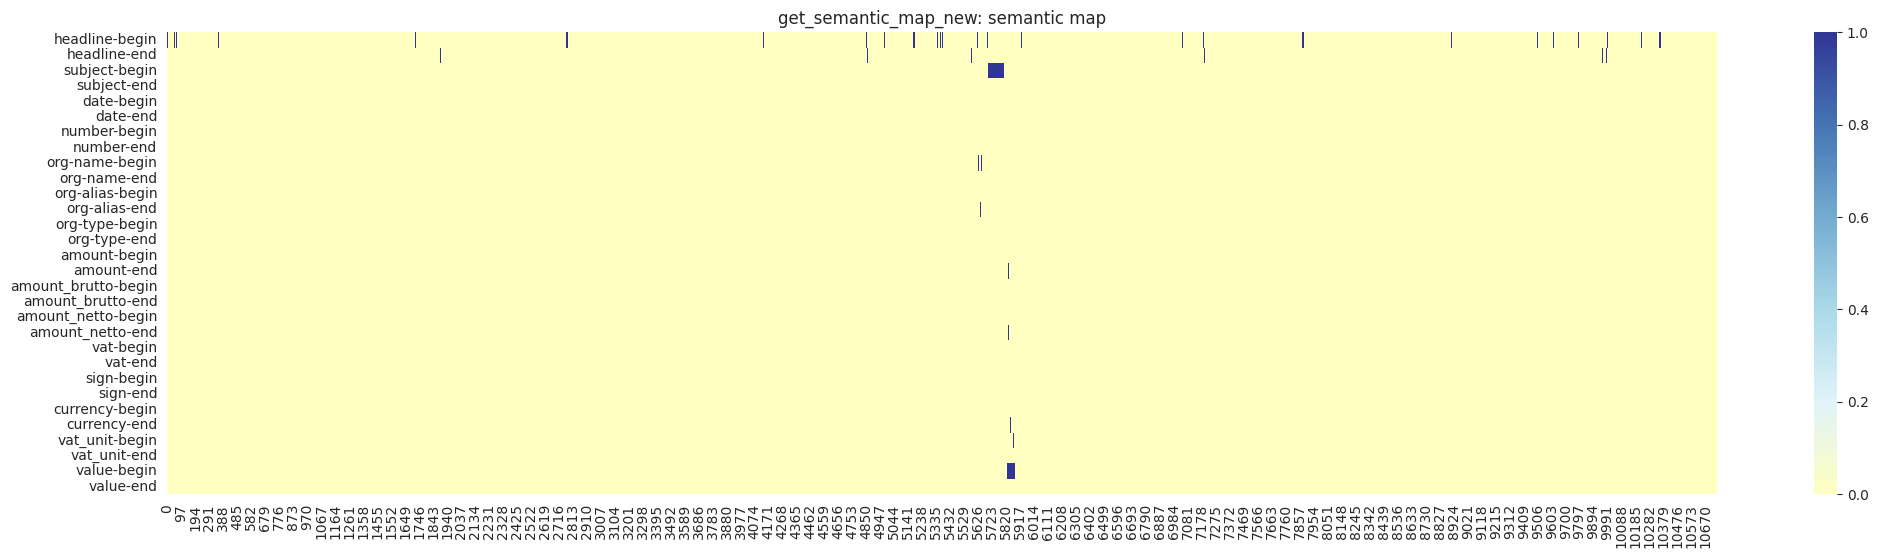

In [14]:
#test one

d = get_doc_by_id(ObjectId('636dfd1473925c8dae26f910'))
if d is not None:
    jd = DbJsonDoc(d)
    semantic_map: DataFrame = get_semantic_map_new(jd)


    plot_embedding(semantic_map, f'get_semantic_map_new: semantic map')

### Adding data from old json file to the stats table

In [15]:
# fff
files_dict = {}

if file_data:
    k=0
    for d in file_data:
        k+=1 
        jd = DbJsonDoc(d)
    #     print( jd.analysis['analyze_timestamp'])
        files_dict[jd.get_id()] = jd
        try:            
            add_stats_record(jd, stats, source = 'file')
        except Exception as e:
            print(e)
            print(jd.get_id())
#             raise (e)

        if k % 100 == 0:
#             stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=False)
#             stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=False)
#             stats['export_date'] = pd.to_datetime(stats['export_date'], utc=False)
            
    
            print(f'{k} of {len(file_data)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')

            
            
stats.to_csv(export_fn, index=True)
stats.to_csv('tmp.csv', index=True)

print(f'stats saved to {export_fn}')

# del file_data
stats




100 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
200 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
300 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
400 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv

5efdb73b777d4b67a92d533c
500 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
600 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-07 17:45:38.069131,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,ГПН,SUN,SUN,Service,1.0,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,Покупатель,Иідате. тьско-ііо. тиі рафнческое предприятие ...,Поставщик,Deal,1.0,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,Арендатор,"Фонд исследований, инноваций, инвестиций Тюмен...",Арендодатель,Renting,1.0,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,Принципал,Газпромнефть-Снабжение,Агент,AgencyContract,1.0,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,Агент,ГазРромнефть-ГЕО,Принципал,AgencyContract,1.0,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5ee188952281f29204c522dc,file,520bf70b9df1ee9ee999fe870d936a51,1.11.2,2023-02-08 16:32:06.927229,7298.0,2020-06-12 22:43:06.038000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,2020-06-11 08:49:53.635000+00:00,False,CONTRACT,0.0,4.0
5efe9252777d4b67a92d5621,file,ed9385088ed6d9c967a9b68a8d10ecc2,2.0.0,2023-02-08 16:32:15.261759,19504.0,2020-07-03 16:50:25.668000+00:00,65300168.0,17.994505,7412.0,RUB,...,Заказчик,Шлюмберже Лоджелко Инк.,Исполнитель,None,NaN,NaT,False,CONTRACT,0.0,26.0
5efe9280777d4b67a92d56ce,file,02a4101c17ceaa4b9d473f6840ac4d7a,2.0.0,2023-02-08 16:32:16.487385,14025.0,2020-07-03 21:47:22.279000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaT,False,CONTRACT,0.0,2.0
5efe9288777d4b67a92d56d3,file,33f326573547c95e1d381eecd79136a2,2.0.0,2023-02-08 16:32:16.793336,19219.0,2020-07-03 21:15:51.170000+00:00,NaN,NaN,NaN,NaN,...,Заказчик,Газпромнефть-Сахалин,Исполнитель,None,NaN,NaT,False,CONTRACT,0.0,25.0


In [16]:
# stats = stats.drop('63c506afe2456d59975e0fcd')
stats[stats.index.duplicated()]



,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers


In [17]:
invalid = stats[stats['valid']==False]
print(f'{len(invalid)}: number of invalid records')
invalid

119: number of invalid records


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers
6294a953df54d406a99b1607,db,2b4fc710def608f726016b949c86ec86,3.0.0,2023-01-31 18:20:56.047027,207.0,2022-05-30 14:24:45.531000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.982557,NaT,False,ANNEX,0.0,4.0
6294af5cdf54d406a99b165e,db,258682c33a03f3707e03e14e03f2b242,3.0.0,2023-01-31 18:20:56.166574,252.0,2022-05-30 15:04:23.498000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.982506,NaT,False,ANNEX,0.0,4.0
629f4d8a41f3e78db0acc635,db,7a018a797f9605e6c1853d7c9b1c3b5d,3.0.0,2023-01-31 18:20:56.582481,604.0,2022-06-07 16:09:07.302000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.989186,NaT,False,ANNEX,0.0,1.0
62a99e0e326a4191e5f173a2,db,6bf0cc61156be1e2d7a35219670b6510,3.0.0,2023-01-31 18:20:56.679454,438.0,2022-06-15 12:06:25.033000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.949933,NaT,False,ANNEX,0.0,2.0
62c545bae599c73b751b78f9,db,9ebef33861ef9a35c21623e9d6f081e8,3.0.0,2023-01-31 18:20:58.097324,494.0,2022-07-06 11:21:02.486000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.949299,NaT,False,ANNEX,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5ee188952281f29204c522dc,file,520bf70b9df1ee9ee999fe870d936a51,1.11.2,2023-02-08 16:32:06.927229,7298.0,2020-06-12 22:43:06.038000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,2020-06-11 08:49:53.635000+00:00,False,CONTRACT,0.0,4.0
5efe9252777d4b67a92d5621,file,ed9385088ed6d9c967a9b68a8d10ecc2,2.0.0,2023-02-08 16:32:15.261759,19504.0,2020-07-03 16:50:25.668000+00:00,65300168.0,17.994505,7412.0,RUB,...,Заказчик,Шлюмберже Лоджелко Инк.,Исполнитель,None,NaN,NaT,False,CONTRACT,0.0,26.0
5efe9280777d4b67a92d56ce,file,02a4101c17ceaa4b9d473f6840ac4d7a,2.0.0,2023-02-08 16:32:16.487385,14025.0,2020-07-03 21:47:22.279000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaT,False,CONTRACT,0.0,2.0
5efe9288777d4b67a92d56d3,file,33f326573547c95e1d381eecd79136a2,2.0.0,2023-02-08 16:32:16.793336,19219.0,2020-07-03 21:15:51.170000+00:00,NaN,NaN,NaN,NaN,...,Заказчик,Газпромнефть-Сахалин,Исполнитель,None,NaN,NaT,False,CONTRACT,0.0,25.0


In [18]:
# !tail /root/artem/work/contract_trainset_meta.temp.csv

# Fetch fresh docs from Mongo DB

In [19]:


# if True:
lastdate = lastdate + relativedelta(days=-5)
#     lastdate = datetime.combine(lastdate, datetime.min.time())

lastdate = pd.to_datetime( lastdate , utc=True)
lastdate

Timestamp('2023-02-02 17:29:24.606000+0000', tz='UTC')

datetime.datetime(2023, 2, 7, 16, 37, 56, 151461)

In [62]:
yesterday = datetime.now() + relativedelta(days=-1)  
# {'analysis.analyze_timestamp': {'$gt': yesterday}},



query = {'user.updateDate': {'$gt': yesterday}}
db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
                               ).limit(5000)

_r = list([i for i in res])
# print(res[0])
_s = f"#### Всего размечено документов после {yesterday} : {len(_r)}"
display(Markdown(_s))
yseterday_ids=[i["_id"] for i in _r]


#### Всего размечено документов после 2023-02-07 16:43:50.603818 : 29

In [45]:
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },
      
#     {"state": 15},
    {'$or': [
          {"analysis.attributes_tree": {"$ne": None}},
          {"user.attributes_tree": {"$ne": None}}
        ]},
#       {'$and': [
#           {"user.updateDate": {"$ne": None}},
#           {'user.updateDate': {'$gt': lastdate}}
#       ]}
#     {"user.attributes_tree.contract.people": {"$ne": None}}

    #     {'$or': [
    #         {"user.attributes_tree.contract.price.amount_netto": {"$ne": None}},
    #         {"user.attributes_tree.contract.price.amount_brutto": {"$ne": None}}
    #     ]}
    {'$or': [
      {'analysis.analyze_timestamp': {'$gt': lastdate}}, 
      {'user.updateDate': {'$gt': lastdate}}
    ]}
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])
# print(res[0])
_s = f"#### Всего новых документов после {lastdate} : {len(res)}"
display(Markdown(_s))

res[:4]

#### Всего новых документов после 2023-02-02 17:29:24.606000+00:00 : 338

[{'_id': ObjectId('5ec2b8d9665f7603e03b1234'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 12,
  'user': {'updateDate': datetime.datetime(2023, 2, 8, 10, 51, 37, 672000)}},
 {'_id': ObjectId('5ec2b8da665f7603e03b1255'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 12,
  'user': {'updateDate': datetime.datetime(2023, 2, 6, 10, 57, 2, 292000)}},
 {'_id': ObjectId('5ec2b8db665f7603e03b1282'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 12,
  'user': {'updateDate': datetime.datetime(2023, 2, 8, 7, 56, 54, 646000)}},
 {'_id': ObjectId('5fb27c24d8c9df1ed1236e43'),
  'user': {'updateDate': datetime.datetime(2023, 2, 6, 12, 24, 14, 80000)},
  'state': 15,
  'parse': {'documentType': 'CONTRACT'}}]

# Prepare training set

In [21]:
new_docs_ids = docs_ids = [i["_id"] for i in res]
print(len(new_docs_ids))
# sample_id = ObjectId('637f7bf0e712cc2ff2e943d3')

# sample_id = docs_ids[1]
# sample_id
# d = get_doc_by_id(sample_id)

# jd = DbJsonDoc(d)
# jd.get_id()
# print(d['_id'])


#==========================Test 1 doc
    
# print(jd.get_version_string())
 
# add_stats_record(jd, stats)
# stats.loc[str(jd._id)]
 

337


In [23]:
# plot_embedding(get_semantic_map_new(jd)[:300], f'semantic map')
# print(len(docs_ids))

In [24]:
def add_to_stats_list(docs_ids):
    for k, oid in enumerate(docs_ids):
        d = get_doc_by_id(ObjectId(str(oid)))
        try:
            jd = DbJsonDoc(d)
            add_stats_record(jd, stats)
        except Exception as e:
            print(oid)
            print (e)

        if k % 100 == 0:
            print(f'{k} of {len(docs_ids)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')
        
add_to_stats_list(docs_ids)        
stats.to_csv(export_fn, index=True)
print(f'stats saved to {export_fn}')
stats

0 of 337
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
100 of 337
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
200 of 337
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
300 of 337
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-08 16:32:20.569785,5847.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,ГПН,SUN,SUN,Service,1.000000,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2.970000e+03,7.996654,1364.0,RUB,...,Покупатель,Иідате. тьско-ііо. тиі рафнческое предприятие ...,Поставщик,Deal,1.000000,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,9.000000e+04,11.407576,1834.0,RUB,...,Арендатор,"Фонд исследований, инноваций, инвестиций Тюмен...",Арендодатель,Renting,1.000000,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,Принципал,Газпромнефть-Снабжение,Агент,AgencyContract,1.000000,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,1.548241e+07,16.555215,699.0,RUB,...,Агент,ГазРромнефть-ГЕО,Принципал,AgencyContract,1.000000,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63ac1fab862ea92bf713c522,db,4d417b69186aebd5fca04e390473600b,23.2.7,2023-02-08 16:32:26.820230,14668.0,2023-02-07 17:27:22.216000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,NaN,NaT,False,CONTRACT,0.0,97.0
63a4306dbeaa9eeec65ecafe,db,3bc04887446d02692e886db2545bba61,23.2.7,2023-02-08 16:32:27.043898,13410.0,2023-02-07 17:27:25.210000+00:00,0.000000e+00,0.000000,2572.0,RUB,...,Гарант,None,Принципал,BankGuarantees,0.999653,NaT,False,AGREEMENT,0.0,21.0
63c506cde2456d59975e12e6,db,d4c224c746af80e3b26d17563acc0112,23.2.7,2023-02-08 16:32:32.263439,581.0,2023-02-07 17:28:16.977000+00:00,1.200000e+01,2.564949,251.0,RUB,...,Заказчик,Рога и копыта,Исполнитель,Other,0.661803,NaT,False,CONTRACT,0.0,1.0
63c506c7e2456d59975e1223,db,aec511aa010b6684d2db1700ad6fc426,23.2.7,2023-02-08 16:32:35.883099,19510.0,2023-02-07 17:29:06.679000+00:00,3.875564e+04,10.565057,4260.0,RUB,...,ЗАКАЗЧИК,None,ИСПОЛНИТЕЛЬ,Service,0.999310,NaT,False,CONTRACT,0.0,29.0


In [25]:
# _ids = list(
#     stats[stats['source']=='db']
#     [stats['documentType']=='undefined'][ stats['user_correction_date'].notna()].index)


# add_to_stats_list(_ids)        
# stats.to_csv(export_fn, index=True)

s = stats[ stats['source']=='db'] 
# s = s[s['documentType']=='CONTRACT']
# s = s[s['subj_len'].isna()]
# s = s[s['user_correction_date'].notna()]
# s = s[s['value']>0]
_ids = list(s[s['headers'].isna()].index)
print(len(_ids))
add_to_stats_list(_ids)     
print(f'saving to {export_fn}; {len(stats)} records')
stats.to_csv(export_fn, index=True)

13
637397e2a8eb8dc64b37543b
'NoneType' object is not iterable
0 of 13
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
637397e2a8eb8dc64b37543c
'NoneType' object is not iterable
637397e2a8eb8dc64b37543d
'NoneType' object is not iterable
637397e2a8eb8dc64b37543f
'NoneType' object is not iterable
637397e2a8eb8dc64b375440
'NoneType' object is not iterable
637397e2a8eb8dc64b375441
'NoneType' object is not iterable
637397e2a8eb8dc64b37543a
'NoneType' object is not iterable
637397e2a8eb8dc64b37543e
'NoneType' object is not iterable
637e11d66a07f3e980b2bfbf
'NoneType' object is not iterable
637e11d76a07f3e980b2bfc0
'NoneType' object is not iterable
637f2826fe09513dc6b2bfbf
'NoneType' object is not iterable
637f2826fe09513dc6b2bfc0
'NoneType' object is not iterable
637f725ec15a83c52bb2bfc1
'NoneType' object is not iterable
saving to /root/artem/work/contract_trainset_meta.temp.csv; 6547 records


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


In [26]:
stats = stats[stats.valid!=False]
len(stats)

6339

In [27]:
stats2 = stats.copy()
stats2['org-2-alias'] = stats2['org-2-alias'].str.lower()
stats2['org-1-alias'] = stats2['org-1-alias'].str.lower()
stats2['org-1-name'] = stats2['org-1-name'].str.lower()
stats2['org-2-name'] = stats2['org-2-name'].str.lower()
stats2

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-08 16:32:20.569785,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,гпн,sun,sun,Service,1.000000,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,покупатель,иідате. тьско-ііо. тиі рафнческое предприятие ...,поставщик,Deal,1.000000,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,арендатор,"фонд исследований, инноваций, инвестиций тюмен...",арендодатель,Renting,1.000000,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,принципал,газпромнефть-снабжение,агент,AgencyContract,1.000000,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,агент,газрромнефть-гео,принципал,AgencyContract,1.000000,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63c506b9e2456d59975e10af,db,7316ad5f69f3c35f2c03aa23331bb9e2,23.2.7,2023-02-08 16:32:37.103712,11369.0,2023-02-07 17:29:22.453000+00:00,NaN,NaN,NaN,NaN,...,гарант,None,принципал,BankGuarantees,0.978081,NaT,True,CONTRACT,10.0,16.0
63c506b9e2456d59975e10b3,db,0c028edaf60667d38b29a12999772a0a,23.2.7,2023-02-08 16:32:37.159629,8266.0,2023-02-07 17:29:23.164000+00:00,142956000.0,18.778047,1033.0,RUB,...,заказчик,газпромнефть нтц,исполнитель,Service,1.000000,NaT,True,CONTRACT,55.0,40.0
63c506aee2456d59975e0fc5,db,e1d782e9e5ce6e55863b7f53ced83e51,23.2.7,2023-02-08 16:32:37.206848,2250.0,2023-02-07 17:29:23.999000+00:00,NaN,NaN,NaN,NaN,...,заказчик,роса,исполнитель,Service,0.955178,NaT,True,CONTRACT,32.0,20.0
63c506bae2456d59975e10bc,db,6fdd4b665d3fea0ff2e8206a2eee1ccb,23.2.7,2023-02-08 16:32:37.254177,7547.0,2023-02-07 17:29:24.606000+00:00,10000.0,9.210440,5460.0,RUB,...,покупатель,квартет,поставщик,Deal,1.000000,NaT,True,CONTRACT,29.0,19.0


In [28]:
stats2['subject'].value_counts()

Other                                2352
Service                              2149
Deal                                  514
Renting                               206
GeneralContract                       203
Loans                                 191
AgencyContract                         97
DealIntellectualProperty               96
Charity                                81
Insurance                              59
RealEstate                             38
ParticipationInOtherOrganizations      26
RealEstateTransactions                 21
PledgeEncumbrance                      20
BankGuarantees                         18
SecuritiesTransactions                 11
AssetTransactions                       2
BigDeal                                 2
EmployeeContracts                       2
Name: subject, dtype: int64

In [29]:
stats2['org-1-alias'].value_counts()

заказчик                    1552
исполнитель                  631
покупатель                   355
поставщик                    163
продавец                     138
                            ... 
промкатализ                    1
таможенный представитель       1
комитент                       1
издатель                       1
гпн                            1
Name: org-1-alias, Length: 96, dtype: int64

In [30]:
stats2['org-2-alias'].value_counts()

исполнитель            1248
заказчик                667
поставщик               300
покупатель              274
подрядчик               268
                       ... 
поверенный                1
жертвователь              1
правительство             1
издатель                  1
сетевая организация       1
Name: org-2-alias, Length: 97, dtype: int64

In [31]:
score_column_name = "score"

def calc_no_value_importance(stats2, column_name, score_k=2.):
        
    for i, row in stats2.iterrows():
        if pd.isna(row[column_name]):
            stats2.at[i, score_column_name] *= score_k
                
def calc_user_importance(stats2):
        
    for i, row in stats2.iterrows():
        if not pd.isna(row['unseen']):

            if row['unseen'] == True:
                stats2.at[i, score_column_name] *= 2
                
def calc_val_importance(stats2):
 
    for i, row in stats2.iterrows():
        if not pd.isna(row['value']):
            val = row['value']
            if val >= 2000:
                stats2.at[i, score_column_name] *= 1./log1p(val)
            if val < 2000:
                stats2.at[i, score_column_name] *= 4.
        else:
            stats2.at[i, score_column_name] *= 10.0 #error
            
def calc_column_val_importance(stats2, column_name, k=1.):
    counts = stats2[column_name].value_counts()
 
        
    for i, row in stats2.iterrows():
        val = row[column_name]
        if val in counts:
            count = counts[val]
            stats2.at[i, score_column_name] *= k * log1p(count)
#             print(count, log1p(count),  1./log1p(count))
        else:
            stats2.at[i, score_column_name] *= 10.0 #error

            
for i, row in stats2.iterrows():        
  stats2.at[i, 'url'] = f'http://gpn-audit.nemosoft.ru/#/audit/edit/{i}'

    
stats2 ['unseen'] = pd.isna( stats2['user_correction_date'])

stats2[score_column_name] = 1.
 

calc_no_value_importance(stats2, 'org-1-alias', 2.)
calc_no_value_importance(stats2, 'org-2-alias', 2.)
calc_no_value_importance(stats2, 'org-1-name', 3.)
calc_no_value_importance(stats2, 'org-2-name', 3.)
calc_no_value_importance(stats2, 'user_correction_date', 10.)
calc_no_value_importance(stats2, 'subject', 4.)
calc_no_value_importance(stats2, 'value', 5.)

## calc_column_val_importance(stats2, 'org-1-name')
## calc_column_val_importance(stats2, 'org-2-name')

calc_column_val_importance(stats2, 'org-1-alias')
calc_column_val_importance(stats2, 'org-2-alias')
calc_column_val_importance(stats2, 'subject', k = 3.)

calc_user_importance(stats2)
calc_val_importance(stats2)

# drop_duplicates(subset=['checksum']).
stats2 = stats2.sort_values([score_column_name], ascending=True)
print(len(stats2))
stats2.head(40)

6339


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,url,unseen,score
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-08 16:32:20.569785,5847.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,Service,1.000000,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,0.648909
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-02-08 16:32:03.632282,1373.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,AgencyContract,0.646182,2020-07-18 12:24:26.280000+00:00,True,CONTRACT,106.0,10.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,0.655233
5ded4e284ddc27bcf92dd6ce,file,9a44591c17d2b8f34dc8f1c3600c8c3a,1.11.2,2023-02-08 16:31:59.907252,460.0,2020-06-12 21:09:19.574000+00:00,5.900000e+05,13.287880,150.0,RUB,...,Charity,0.000000,2020-06-09 00:40:54.752000+00:00,True,CONTRACT,30.0,5.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,False,0.757619
63ce49f8e83d1ee490f3f21c,db,25d924fc09b7291d964f464f9c3ec8c3,23.1.27.1,2023-02-03 16:19:06.576376,8535.0,2023-01-28 09:34:50.691000+00:00,3.000000e+09,21.821878,337.0,RUB,...,Loans,1.000000,2023-01-28 01:38:49.198000+00:00,True,CONTRACT,53.0,12.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,False,1.153584
6285f9c04d1bfe5e5b297ddd,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-02-01 17:26:53.153480,5556.0,2022-05-19 11:03:36.611000+00:00,1.000000e+11,25.328436,1505.0,RUB,...,SecuritiesTransactions,1.000000,2023-01-27 11:32:42.657000+00:00,True,CONTRACT,37.0,17.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6285...,False,1.692323
633fd0a69d08c565cfa1232a,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-02-01 17:26:54.225685,5556.0,2022-10-07 10:10:07.028000+00:00,1.000000e+11,25.328436,1505.0,RUB,...,SecuritiesTransactions,1.000000,2023-01-27 11:36:12.388000+00:00,True,CONTRACT,37.0,17.0,http://gpn-audit.nemosoft.ru/#/audit/edit/633f...,False,1.692323
6246a3fa25a983726c7694af,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-01-31 18:32:42.511519,5556.0,2022-04-01 10:21:21.897000+00:00,1.000000e+11,25.328436,1505.0,NaN,...,SecuritiesTransactions,1.000000,2022-04-01 07:27:01.064000+00:00,True,CONTRACT,37.0,17.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6246...,False,1.692323
63908ca4a1bded13e629f2eb,db,3bc04887446d02692e886db2545bba61,22.12.7,2023-01-31 18:38:08.500901,13410.0,2022-12-08 13:59:29.898000+00:00,2.000000e+10,23.718998,2572.0,RUB,...,BankGuarantees,1.000000,2022-12-08 11:04:21.263000+00:00,True,AGREEMENT,84.0,21.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,1.805167
5fbf75af5d05d73d0295fa99,db,9f0be084f7a24f3b408dd5baf95195c3,2.0.5,2023-02-01 17:26:52.850349,3265.0,2020-11-26 13:00:29.583000+00:00,1.043565e+06,13.858154,590.0,RUB,...,Renting,1.000000,2023-01-27 11:47:27.668000+00:00,True,CONTRACT,29.0,19.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fbf...,False,2.041189
5ec2b8da665f7603e03b127e,db,71d364cbfd07a7a940a8d7de159e1229,1.6.5,2023-01-31 18:32:27.545209,4766.0,2020-05-18 18:26:50.950000+00:00,1.000000e+09,20.723266,394.0,RUB,...,BankGuarantees,1.000000,2021-10-29 16:28:20.936000+00:00,True,CONTRACT,75.0,3.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,2.066120


In [32]:
# sub = stats2.sort_values(['score'], ascending=True).copy()
# sub

## Find and remove duplicates

In [33]:
stats2['len'] //= 10 #similar lens
stats2['len'] *= 10 #similar lens
stats2.sort_values(['len', 'org-1-name', 'org-2-name', 'org-1-alias','org-2-alias', 'value', 'subject'], ascending=False)

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,url,unseen,score
5fc7a047c54bc33809e26372,db,82137d4b0ded9b81b1d12f4d9e98c383,2.0.5,2023-01-31 18:21:21.813526,49340.0,2020-12-03 08:07:48.699000+00:00,90619807.0,18.322183,4503.0,RUB,...,Service,0.896091,NaT,True,CONTRACT,44.0,53.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7...,True,3.692731e+03
5fca2acd9083b679224c77da,db,6b64d52e5ecb4941696164ed4950e735,2.0.5,2023-01-31 18:21:28.019257,49040.0,2020-12-10 10:40:36.652000+00:00,90619807.0,18.322183,4207.0,RUB,...,GeneralContract,1.000000,2021-07-30 21:59:37.858000+00:00,True,CONTRACT,44.0,44.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,False,3.579692e+01
5fb3b9a800881c332b567433,db,287d93101b752b5f041d476d7196864e,2.0.5,2023-01-31 18:21:09.911469,44180.0,2020-11-17 11:54:59.086000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,True,CONTRACT,0.0,52.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,1.440000e+08
5fca2ac89083b679224c7786,db,8175a19a30e81fda3cc0f92e46a7dcfe,2.0.5,2023-02-08 16:32:22.459244,43930.0,2020-12-10 06:21:54.242000+00:00,11285139.0,16.238997,4251.0,RUB,...,GeneralContract,1.000000,2023-02-06 11:48:06.685000+00:00,True,CONTRACT,255.0,50.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,False,4.038905e+01
5f09a55a138e9184feef1f3d,file,1a9db8f1670e2e976b777841a0cd3412,2.0.4,2023-02-08 16:32:18.420054,39860.0,2020-10-04 10:50:52.531000+00:00,NaN,NaN,NaN,NaN,...,Service,1.000000,2020-10-04 02:48:25.763000+00:00,True,CONTRACT,118.0,4.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5f09...,False,1.956589e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63c506bde2456d59975e110e,db,109407c8fd295cd3e3bf6c51ae8c8c4f,23.01.04,2023-01-31 18:38:08.879568,10.0,2023-01-16 11:36:52.238000+00:00,NaN,NaN,NaN,NaN,...,Other,0.960716,NaT,True,ANNEX,0.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,8.384522e+07
638f0a7fb1363747e929f2eb,db,6ab9d3f7bc1bc9a222f4490866b01365,22.12.6,2023-01-31 18:38:07.383103,10.0,2022-12-06 12:27:52.103000+00:00,NaN,NaN,NaN,NaN,...,Other,0.984600,NaT,True,ANNEX,0.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/638f...,True,8.384522e+07
638f0a7fb1363747e929f2ec,db,109407c8fd295cd3e3bf6c51ae8c8c4f,22.12.6,2023-01-31 18:38:07.384039,10.0,2022-12-06 12:27:52.306000+00:00,NaN,NaN,NaN,NaN,...,Other,0.984498,NaT,True,ANNEX,0.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/638f...,True,8.384522e+07
638f0a7fb1363747e929f2ef,db,16bbfb78a184b3f37e6c9866aa4c94d9,22.12.6,2023-01-31 18:38:07.386171,10.0,2022-12-06 12:27:52.856000+00:00,NaN,NaN,NaN,NaN,...,Other,0.982682,NaT,True,ANNEX,0.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/638f...,True,8.384522e+07


In [34]:
for i, row in stats2.iterrows():
  _str = ':'.join(sorted([str(x) for x in
                          [row['len'], row['org-1-alias'], row['org-2-alias'], row['org-1-name'], row['org-2-name'],
                           row['value'], row['subject']]]))
  stats2.at[i, 'hash'] = hash(_str)

stats2 = stats2.sort_values(['hash'])
print(len(stats2))
stats2

6339


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject confidence,user_correction_date,valid,documentType,subj_len,headers,url,unseen,score,hash
63ce4a7ce83d1ee490f3f9d7,db,c38f3e05c41726403edc7b0fe3e9d71e,23.01.23,2023-01-31 21:43:19.421732,2150.0,2023-01-25 08:07:08.379000+00:00,4.526276e+06,15.325410,599.0,RUB,...,0.979302,NaT,True,CONTRACT,53.0,20.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,1.260090e+03,-9.222188e+18
63ce4a38e83d1ee490f3f5cc,db,015cdb11c95f74db9242601ef7ad145d,23.01.23,2023-01-31 21:43:08.232691,10570.0,2023-01-24 23:29:34.905000+00:00,NaN,NaN,NaN,NaN,...,0.978596,NaT,True,CONTRACT,78.0,35.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,4.205942e+05,-9.216640e+18
5fb3d49f78df3635f5441c0a,db,9b2a7b8677e6cc8513d8f5bfa870721f,2.0.5,2023-01-31 18:36:00.714594,3530.0,2020-11-17 14:24:45.522000+00:00,NaN,NaN,NaN,NaN,...,0.667946,NaT,True,CONTRACT,58.0,22.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,5.769554e+05,-9.216595e+18
5edbc636da3678279fbcae13,file,fdd14f9e664e0d02973ee291ef67f412,2.0.2,2023-02-08 16:32:03.725670,3770.0,2020-07-14 11:06:10.219000+00:00,NaN,NaN,NaN,NaN,...,0.998235,2020-07-14 03:04:18.624000+00:00,True,CONTRACT,44.0,12.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,6.030182e+04,-9.215414e+18
5ec2b8d8665f7603e03b122b,db,cc4b2aafacbb7b78598e7f9432950afa,1.6.5,2023-02-07 17:45:38.139273,1190.0,2020-05-21 14:57:47.894000+00:00,1.500000e+10,23.431316,146.0,RUB,...,1.000000,2023-02-02 14:26:08.111000+00:00,True,CONTRACT,52.0,11.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,1.210878e+01,-9.214211e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62a99d94326a4191e5f17393,db,e36d81f21cc6337bc56c299a2abc3b0c,3.0.0,2023-01-31 18:20:56.672685,200.0,2022-06-15 11:59:12.341000+00:00,NaN,NaN,NaN,NaN,...,0.940691,NaT,True,ANNEX,0.0,5.0,http://gpn-audit.nemosoft.ru/#/audit/edit/62a9...,True,8.384522e+07,9.212752e+18
5efe923c777d4b67a92d554b,file,6cc02e25851b3f53c4170b7905d2aeca,2.0.0,2023-02-08 16:32:10.372187,3600.0,2020-07-03 11:03:45.939000+00:00,4.000000e+05,12.899222,779.0,RUB,...,0.998199,NaT,True,CONTRACT,60.0,15.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5efe...,True,1.869937e+03,9.213150e+18
63ce4a68e83d1ee490f3f88f,db,5acaf8d0416bc4b1111130e3adcd9d35,23.01.23,2023-01-31 18:38:23.162869,40.0,2023-01-23 20:09:09.584000+00:00,NaN,NaN,NaN,NaN,...,0.829671,NaT,True,ANNEX,40.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,8.287081e+07,9.213795e+18
5fe48220b770574a00555768,db,042dfd29490e024f0708fca98da832c0,2.3.13,2023-01-31 18:36:06.247407,1970.0,2020-12-24 17:59:24.738000+00:00,NaN,NaN,NaN,NaN,...,0.992922,NaT,True,CONTRACT,47.0,9.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fe4...,True,3.355034e+05,9.216933e+18


In [35]:
unks = stats2['hash'].value_counts()

for i, row in stats2.iterrows():   
    stats2.at[i, 'dups'] = unks[row['hash']]
    
dups = stats2.sort_values(['dups', 'hash'], ascending=False)
# dups.to_csv(Path(work_dir) / 'contract_trainset_meta.duplicates.csv', index=True)

# dups[40:].head(40)
len(dups)

6339

### Drop duplicates

In [36]:
dups_s = dups.sort_values([score_column_name], ascending=True).copy()

dups_s = dups_s.drop_duplicates(subset=['hash'])
dups_s = dups_s.sort_values([score_column_name], ascending=True)


dups_s = dups_s.sort_values([score_column_name], ascending=True)
# dups_s = dups_s[dups_s[score_column_name] < 5000]
print(len(dups_s))

# dups_s [dups_s['len'] > 30000].head(40)

3195


## Remove rare subjects and very long docs

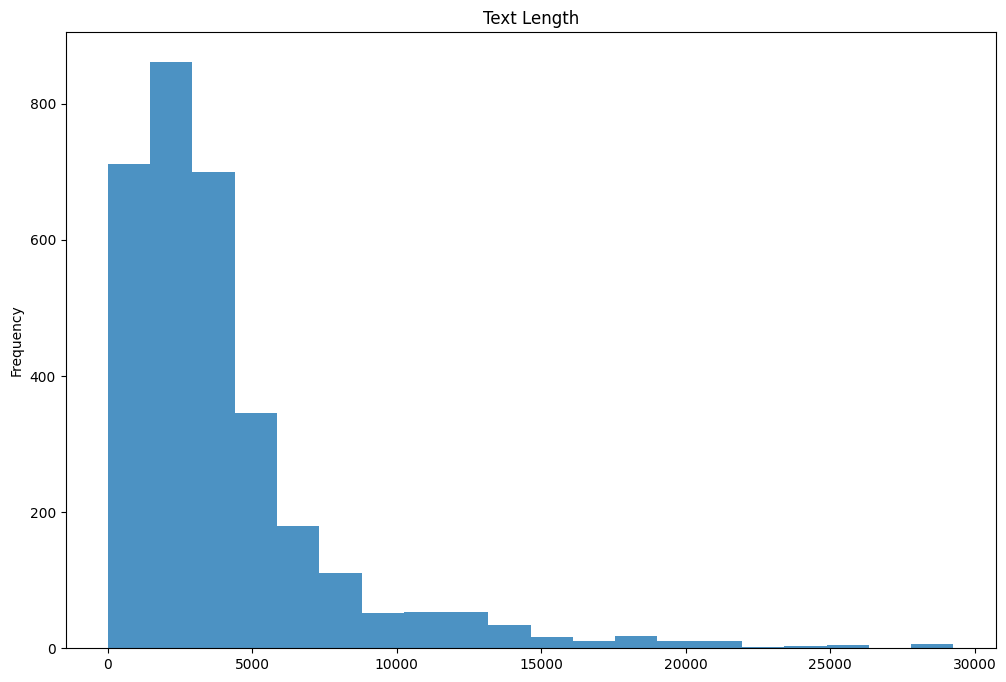

In [37]:
plt.figure(figsize=(12, 8))
ax = dups_s[dups_s['len'] < 30000] ['len'].plot.hist(bins=20, alpha=0.8)
ax.set_title('Text Length')
plt.show()

0.6489088602394992


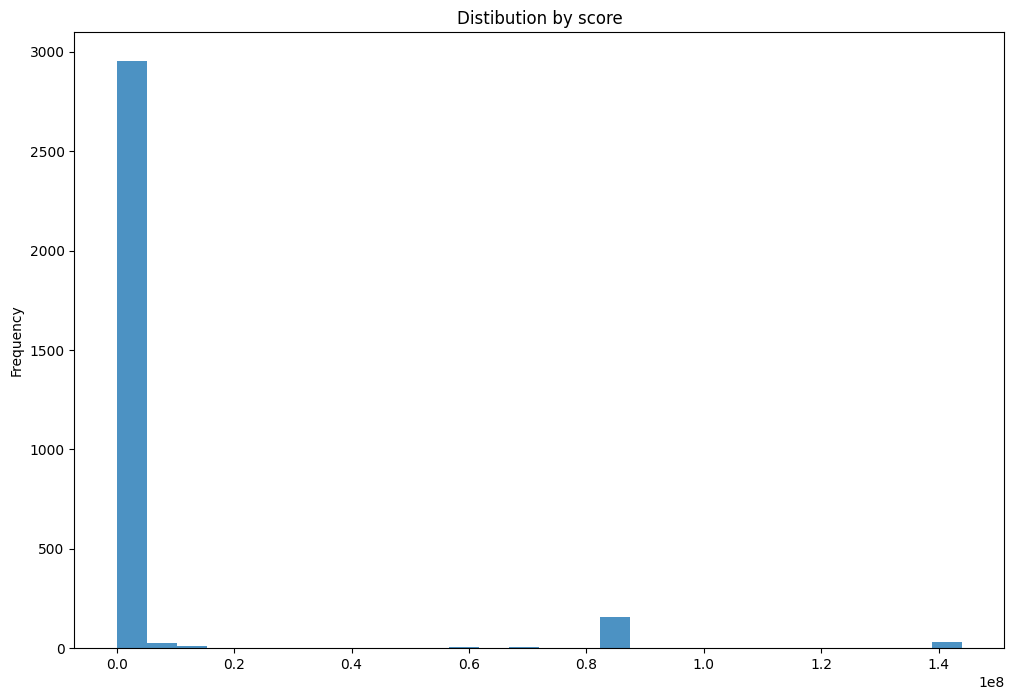

In [38]:
print(dups_s[score_column_name].min())
plt.figure(figsize=(12, 8))
ax = dups_s[score_column_name].plot.hist(bins=28, alpha=0.8)
ax.set_title('Distibution by score')
plt.show()

In [39]:

dups_s['valid'] = True

print("excluding too long docs")
for i, row in dups_s.iterrows():   
    if row['len'] > 30000:
        print ('excluding', i, row[0], row['subject'], row['len'])
        dups_s.at[i, 'valid'] = False  
        
dups_s = dups_s[dups_s['valid'] == True]

print("excluding docs with rare subj")
cnts = dups_s ['subject'].value_counts()
for i, row in dups_s.iterrows():   
    if not pd.isna(row['subject']):
        if cnts[row['subject']] < 3:
            print ('excluding', i, row[0], row['subject'])
            dups_s.at[i, 'valid'] = False

dups_s = dups_s[dups_s['valid'] == True]  

excluding too long docs
excluding 5e58df7823869ee43538823d file GeneralContract 31090.0
excluding 5fbf75c75d05d73d0295fac0 db GeneralContract 38360.0
excluding 5fca2acd9083b679224c77da db GeneralContract 49040.0
excluding 5fca2ac89083b679224c7786 db GeneralContract 43930.0
excluding 5fca2ac79083b679224c774f db GeneralContract 39310.0
excluding 5f9672f182451803b5001df7 db GeneralContract 31170.0
excluding 5e5de70d01c6c73c19eebd4a file GeneralContract 31090.0
excluding 5fc7a047c54bc33809e26372 db Service 49340.0
excluding 5f09a55a138e9184feef1f3d file Service 39860.0
excluding 615e9e978f3b0514f3f42413 db Loans 35800.0
excluding 63ce4ac2e83d1ee490f3fd05 db Other 35560.0
excluding 5fb3b9a800881c332b567433 db nan 44180.0
excluding docs with rare subj
excluding 5feb3e50bd24992aa31040df db AssetTransactions
excluding 5fbbbd1ba2b4551c06107a3d db BigDeal
excluding 5dee80604ddc27bcf92dd88e file EmployeeContracts
excluding 6166dbc387f1d9065bb8b937 db AssetTransactions
excluding 610d2b0d7dfce422c4

Service                              1611
Other                                 424
Deal                                  381
Renting                               149
GeneralContract                       144
Loans                                 104
AgencyContract                         79
DealIntellectualProperty               66
Charity                                50
Insurance                              44
RealEstate                             33
BankGuarantees                         17
RealEstateTransactions                 16
PledgeEncumbrance                      12
ParticipationInOtherOrganizations      12
SecuritiesTransactions                  8
Name: subject, dtype: int64


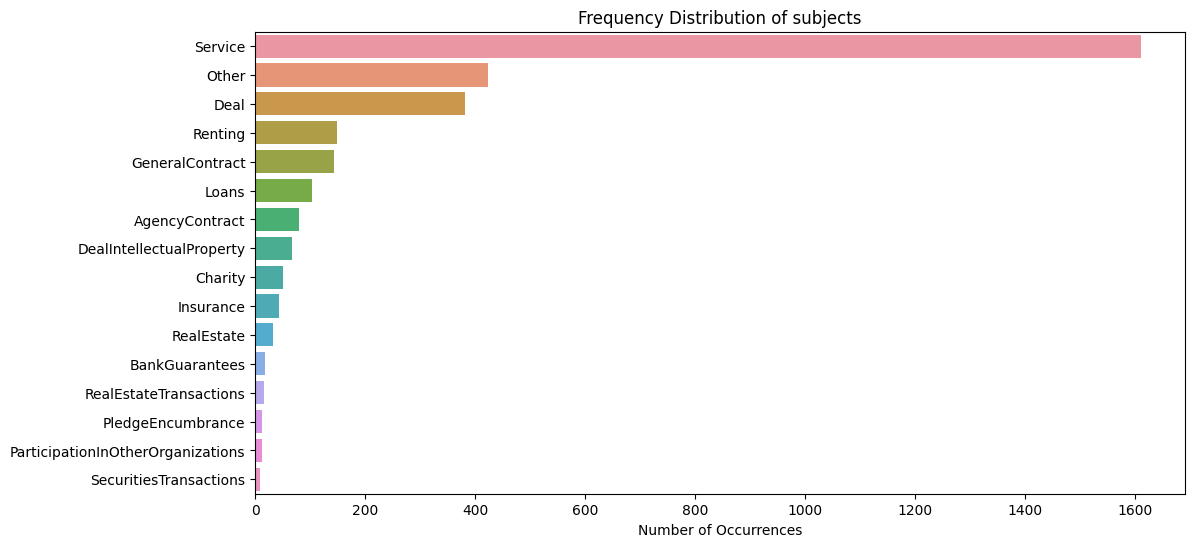

In [40]:
%matplotlib inline

cnt = dups_s['subject'].value_counts()

plt.figure(figsize=(12, 6 ))
sns.barplot(x=cnt.values, y=cnt.index)

print(  cnt )

plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


In [41]:
dups_s.index.name = '_id'
dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)


_s = f"### {len(dups_s)} - Всего новых документов в обучающем наборе на {lastdate}"
display(Markdown(_s))


dups_s

### 3178 - Всего новых документов в обучающем наборе на 2023-02-02 17:29:24.606000+00:00

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,user_correction_date,valid,documentType,subj_len,headers,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-08 16:32:20.569785,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,6.489089e-01,5.058986e+18,1.0
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-02-08 16:32:03.632282,1370.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,2020-07-18 12:24:26.280000+00:00,True,CONTRACT,106.0,10.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,6.552332e-01,-5.635169e+18,1.0
5ded4e284ddc27bcf92dd6ce,file,9a44591c17d2b8f34dc8f1c3600c8c3a,1.11.2,2023-02-08 16:31:59.907252,460.0,2020-06-12 21:09:19.574000+00:00,5.900000e+05,13.287880,150.0,RUB,...,2020-06-09 00:40:54.752000+00:00,True,CONTRACT,30.0,5.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,False,7.576190e-01,-3.254451e+18,1.0
63ce49f8e83d1ee490f3f21c,db,25d924fc09b7291d964f464f9c3ec8c3,23.1.27.1,2023-02-03 16:19:06.576376,8530.0,2023-01-28 09:34:50.691000+00:00,3.000000e+09,21.821878,337.0,RUB,...,2023-01-28 01:38:49.198000+00:00,True,CONTRACT,53.0,12.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,False,1.153584e+00,-6.854663e+18,1.0
633fd0a69d08c565cfa1232a,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-02-01 17:26:54.225685,5550.0,2022-10-07 10:10:07.028000+00:00,1.000000e+11,25.328436,1505.0,RUB,...,2023-01-27 11:36:12.388000+00:00,True,CONTRACT,37.0,17.0,http://gpn-audit.nemosoft.ru/#/audit/edit/633f...,False,1.692323e+00,3.429304e+17,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fb376ecd8c9df1ed1237426,db,cfb946354a667ba0433951e37579acee,2.5.3,2023-01-31 18:37:59.338526,220.0,2021-10-28 16:06:38.824000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,ANNEX,0.0,2.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,1.440000e+08,-8.436892e+18,2.0
5fb674fb33c72547b754ffaa,db,284705dbe8937b02bcd6bb3b77a027cc,2.4.4,2023-01-31 18:37:44.067609,160.0,2021-07-28 18:10:30.003000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,ANNEX,0.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb6...,True,1.440000e+08,-1.018200e+18,18.0
6285f51ff098f73e14297eba,db,40fdd870b1f3bf7fb54e14e017033a7a,3.0.0,2023-01-31 18:38:00.194898,140.0,2022-05-19 10:46:32.782000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,ANNEX,0.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6285...,True,1.440000e+08,-6.184069e+18,24.0


In [42]:
dups_s[dups_s['unseen']].to_csv(Path(work_dir) / 'contract_trainset_meta.to_markup.csv', index=True)

In [43]:
dups_s[dups_s['unseen']]

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,user_correction_date,valid,documentType,subj_len,headers,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
5ec2b8d8665f7603e03b121a,db,74a7be7f14b129ce379aaa0920978a71,1.6.5,2023-01-31 18:32:27.217863,550.0,2020-05-18 16:35:16.047000+00:00,4.900000e+05,13.102163,114.0,RUB,...,NaT,True,CONTRACT,35.0,7.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,True,9.695597e+00,-6.028871e+18,5.0
63c506c1e2456d59975e1186,db,99eb2f07e9493a1e712529bc30359204,23.2.7,2023-02-08 16:32:35.411773,10780.0,2023-02-07 17:29:02.773000+00:00,6.000000e+06,15.607270,4608.0,RUB,...,NaT,True,CONTRACT,35.0,24.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,1.556870e+01,-1.769202e+18,1.0
63c506dce2456d59975e145c,db,88a0bf0e851b84960702680c7972f090,23.01.04,2023-01-31 21:42:43.455407,3630.0,2023-01-16 14:15:20.502000+00:00,4.000000e+06,15.201805,326.0,RUB,...,NaT,True,CONTRACT,95.0,7.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,3.112603e+01,1.139419e+16,2.0
63c506ace2456d59975e0f9f,db,2ff69a29f2a6f16826a6e68dc6cc1d22,23.01.04,2023-01-31 21:42:49.474166,430.0,2023-01-16 14:43:58.035000+00:00,5.500000e+07,17.822844,172.0,RUB,...,NaT,True,SUPPLEMENTARY_AGREEMENT,10.0,5.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,6.797802e+01,-9.310885e+17,1.0
5efe924d777d4b67a92d55b0,file,c056d218b8ae1d56747afd23ac3cf10f,2.0.0,2023-02-08 16:32:12.126295,17580.0,2020-07-03 12:29:32.528000+00:00,1.865870e+08,19.044408,2372.0,RUB,...,NaT,True,CONTRACT,11.0,76.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5efe...,True,7.417005e+01,5.989065e+18,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fb376ecd8c9df1ed1237426,db,cfb946354a667ba0433951e37579acee,2.5.3,2023-01-31 18:37:59.338526,220.0,2021-10-28 16:06:38.824000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,ANNEX,0.0,2.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,1.440000e+08,-8.436892e+18,2.0
5fb674fb33c72547b754ffaa,db,284705dbe8937b02bcd6bb3b77a027cc,2.4.4,2023-01-31 18:37:44.067609,160.0,2021-07-28 18:10:30.003000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,ANNEX,0.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb6...,True,1.440000e+08,-1.018200e+18,18.0
6285f51ff098f73e14297eba,db,40fdd870b1f3bf7fb54e14e017033a7a,3.0.0,2023-01-31 18:38:00.194898,140.0,2022-05-19 10:46:32.782000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,ANNEX,0.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6285...,True,1.440000e+08,-6.184069e+18,24.0


# 🤦 Find markup errors

In [47]:
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },      
    {"user.attributes_tree": {"$ne": None}},
#       {'user.updateDate': {'$gt': lastdate}}    
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])
# print(res[0])
_s = f"#### Всего документов, которые размечены человеком : {len(res)}"
display(Markdown(_s))

# res[:4]



#### Всего документов, которые размечены человеком : 1153

In [48]:
user_docs_ids  = [i["_id"] for i in res]
print('user_docs_ids', len(user_docs_ids))


user_docs_ids 1153


In [72]:



def get_span_val(jd:DbJsonDoc, tag):
    tm = jd.get_tokens_map_unchaged()
    
    span = tag.get('span', [0,0]) 
    
    if span[1]-span[0]==0:
        return None
    
    quote = tm.text_range(span)
    
    return quote

def add_error(userdocs, _id, error_message):    
            
    if error_message:
        missing=False
        if len(error_message)==2:
            error_message, missing = error_message
        
        userdocs.at[_id,'errors count'] = userdocs.at[_id,'errors count']+1
        
        if missing==True:
            userdocs.at[_id, 'error missing']=';\n'.join(  [error_message, userdocs.at[_id,'error missing']] )
        else:
            userdocs.at[_id, 'error']=';\n'.join(  [error_message, userdocs.at[_id,'error']] )
        
#--------        

def validate_date(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
    tag = jd.get_attributes_tree().get('date', {})
    val = get_span_val(jd, tag)
    
    if not val:
        return
#     val = jd.get_tokens_map_unchaged().text_range(span)
    
    df.at[_id,f'Дата'] = val 
       
    
    if '\n' in val:
        return f"Дата содержит перенос строки"
    
    if len(val) > 25:
        return f"Дата слишком длинная"
    
    
def validate_number(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
#     span = jd.get_attributes_tree().get('number', {}).get('span', [0,0])
#     val = jd.get_tokens_map_unchaged().text_range(span)
    
    tag = jd.get_attributes_tree().get('number', {})
    span = tag.get('span', [0,0]) 
    val = get_span_val(jd, tag)
    
    if not val:
        return
    
    
    df.at[_id,f'Номер'] = val 
    
    if 'договор' in val.lower():
        return f"Номер содержит слово"
    
    if '\n' in val:
        return f"Номер содержит перенос строки"
       
    if val.strip() !=val:
        return f"Номер содержит пробелы по краям"
    
    if val.strip()=="№":
        return f"Номер не является номером"
    
    if (span[1]-span[0])>5:
        return f"Номер договора какой-то длинный"

#     if val.strip()[0]=="№":
#         return f"Номер содержит знак №"
        
#     if len(val) > 30:
#         return f"Номер слишком длинный"
    
    
def validate_alias(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
    orgs=jd.get_attributes_tree().get('orgs', [{},{}])
    
    if len(orgs) < i+1:
        return f"Псевдоним {i+1} отсутсвует", True
    
    tag =  orgs[i].get('alias',{})
    val = get_span_val(jd, tag)
    
    if not val:
        return f"Псевдоним {i+1} отсутсвует", True
    
    
    df.at[_id,f'Псевдоним {i+1}'] = val 
    
    if  '«' in val or '»' in val:
        return f"Псевдоним {i+1} содержит кавычки"
    
    if '\n' in val:
        return f"Псевдоним {i+1} содержит перенос строки"
    
    if len(val) > 25:
        return f"Псевдоним {i+1} слишком длинный"
    
    
def validate_org_name(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
    
    orgs=jd.get_attributes_tree().get('orgs', [{},{}])
    
    if len(orgs) < i+1:
        return f"Наименование {i+1} отсутсвует", True
    
    tag = orgs[i].get('name',{})
    val = get_span_val(jd, tag)
    
    if not val:
        return f"Наименование {i+1} отсутсвует", True
    
    df.at[_id,f'Наименование {i+1}'] = val 
    
    if '\n' in val:
        return f"Наименование {i+1} содержит перенос строки"
    
    if '«' in val:
        if '»' not in val:
            return f"Наименование {i+1}: кавычка не закрыта"
    
    if '»' in val:
        if '«' not in val:
            return f"Наименование {i+1}: кавычка не открыта"
        
    if val[0]=='«':
        return f"Наименование {i+1} содержит кавычки"
    
    
def validate_org_type(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
    
    orgs=jd.get_attributes_tree().get('orgs', [{},{}])
    
    if len(orgs) < i+1:
        return f"Форма собственности {i+1} отсутсвует", True
    
    tag = orgs[i].get('type',{})
    val = get_span_val(jd, tag)
    
    if not val:
        return f"Форма собственности {i+1} отсутсвует", True
    
    df.at[_id, f'Форма собственности {i+1}'] = val 
    
    if '\n' in val:
        return f"Форма собственности {i+1}: содержит перенос строки"
    
    if '«' in val:
        if '»' not in val:
            return f"Форма собственности {i+1}: кавычка не закрыта"
    
    if '»' in val:
        if '«' not in val:
            return f"Форма собственности {i+1}: кавычка не открыта"
        
    if val[0]=='«':
        return f"Форма собственности {i+1}: содержит кавычки"
    

def validate_subject_len(jd:DbJsonDoc, df) -> str or None: 
    _id = str(jd._id)
    
    tag = jd.get_attributes_tree().get('subject', {})
    val = get_span_val(jd, tag)
    span = tag.get('span', [0,0]) 
    
    kind = tag.get('value', None) 
    
    
    subject_len = span[1]-span[0]
    
    df.at[_id,'subject len'] = subject_len
    df.at[_id,'subject kind'] = kind
    
    if subject_len > 150:
        df.at[_id,'subject'] = val[:200]
        return f"предмет договора слишком длинный: {subject_len} слов"
    
    if subject_len ==0:
        return f"раздел о предмете договора не указан; определен как [{kind}]"
    
    
def validate_price(jd:DbJsonDoc, df) -> str or None:    
    _id = str(jd._id)
    
    tag = jd.get_attributes_tree().get('price', {})
    
    
    span = tag.get('span', [0,0]) 
        
    _len = span[1]-span[0]
    
#     df.at[_id,'subject len'] = subject_len

    
    
    if not tag:
        return 
    
    price_q = get_span_val(jd, tag)
    df.at[_id,'сумма'] = f"{price_q}"
    
    
    sentence_span1 = jd.get_tokens_map_unchaged().sentence_at_index( span[0])
    sentence_span2 = jd.get_tokens_map_unchaged().sentence_at_index( span[1])
    sentence_span = [ sentence_span1[0], sentence_span2[1]]
    
    
    sentence = jd.get_tokens_map_unchaged().text_range(sentence_span)
    
    amount_name = 'сумма (старая)'
    price_name = 'сумма договора'
    
    
    vat = tag.get('vat')    
    if vat:
        val = get_span_val(jd, vat)    
        df.at[_id, 'налог'] = f'{val}'
        
    vat_unit = tag.get('vat_unit')    
    if vat_unit:
        val = get_span_val(jd, vat_unit)    
        df.at[_id,'vat_unit'] = f'{val}'
        

        
    
    amount_netto = tag.get('amount_netto')    
    if amount_netto:
        val = get_span_val(jd, amount_netto)    
        df.at[_id,'сумма без налога'] = f'{val}'
        
    amount = tag.get('amount')  
    
    if amount:
        val = get_span_val(jd, amount)    
        df.at[_id, amount_name] = f'{val}'
     
        
    amount_brutto = tag.get('amount_brutto')    
    if amount_brutto:
        val = get_span_val(jd, amount_brutto)    
        df.at[_id,'сумма с налогом'] = f'{val}'
        
    currency = tag.get('currency')    
    if currency:
        val = get_span_val(jd, currency)    
        df.at[_id,'currency'] = f'{val}'
        
    
    if vat:
        val = get_span_val(jd, vat)    
        if not val[0].isdigit():
            return  f"налог начинается не с цифры"
     
    #----
    if amount_netto:
        _span = amount_netto.get('span', [0,0])         
        if _span[1]-_span[0] > 4:
            return  f"сумма без налога слишком длинная, должна содержать только число"
    
    #----
    if amount_brutto:
        _span = amount_brutto.get('span', [0,0])         
        if _span[1]-_span[0] > 4:
            return  f"сумма c налогом слишком длинная, должна содержать только число"
        
    #----
    if amount:
        _span = amount.get('span', [0,0])         
        if _span[1]-_span[0] > 4:
            return  f"{amount_name} слишком длинная, должна содержать только число"
    
    
    if amount_netto or amount_brutto:
        if not vat:
            return  f"налог не указан"
    

    if ' штраф ' in sentence.lower() or "страховая сумма " in sentence.lower() or " пени " in sentence.lower() : 
        print('sentence_span', sentence_span, jd.get_tokens_map_unchaged().text_range(sentence_span))
        return  f"сумма вообще не та!!"
        
    if 'ндс' in sentence.lower():
        if not vat:
            return  f"налог не указан"
        
        if not (amount_netto or  amount_brutto):
            return  f"сумма с учетом налога не указана"
        
    if amount_netto or amount_brutto or amount:
        if not currency:
            return  f"валюта не указана"
        
    if vat:
        if not vat_unit:
            return  f"валюта налога не указана"
    
    if tag:
        if not (price_q.strip()[0].isalpha() or price_q.strip()[0].isdigit):
            return  f"раздел о цене начинается не со слова"
        
    if _len > 150:
        return f"{price_name} слишком длинная: {_len} слов"
    
    if _len < 10:
        return f"{price_name} слишком короткая: {_len} слов, нужно: {sentence_span1[1]- sentence_span2[0]}"

####################################### sentence_at_index

def validate_markup(user_docs_ids) -> DataFrame:
  userdocs = DataFrame()
  for k, oid in enumerate(user_docs_ids):
# for k, oid in enumerate(['5fe34f64b770574a005553e6']):    
    _id = str(oid)
    oid = ObjectId(_id)
    d = get_doc_by_id(oid)
    jd = DbJsonDoc(d)
        
    attr_tree = jd.get_attributes_tree()  
#     print('',attr_tree)

    
    userdocs.at[_id,'дата редактирования'] = jd.user['updateDate']
    userdocs.at[_id,'link'] = f'https://gpn-audit.nemosoft.ru/#/audit/edit/{_id}'
    userdocs.at[_id,'error'] = ''
    userdocs.at[_id,'error missing'] = ''
    userdocs.at[_id,'errors count'] = 0

    
    
    if not jd.analysis:
        userdocs.at[_id, 'error'] = "Не анализирован!!"
    
    else:
        add_error(userdocs, _id, validate_subject_len(jd, userdocs) )
        

        add_error(userdocs, _id, validate_org_type(jd, userdocs, 0) )
        add_error(userdocs, _id, validate_org_name(jd, userdocs, 0) )
        add_error(userdocs, _id, validate_alias(jd, userdocs, 0) )
        
        add_error(userdocs, _id, validate_org_type(jd, userdocs, 1) )
        add_error(userdocs, _id, validate_org_name(jd, userdocs, 1) )
        add_error(userdocs, _id, validate_alias(jd, userdocs, 1) )

        add_error(userdocs, _id, validate_date(jd, userdocs) )
        add_error(userdocs, _id, validate_number(jd, userdocs) )
        
        add_error(userdocs, _id, validate_price(jd, userdocs) )
        
  return userdocs
    
userdocs = validate_markup(user_docs_ids)
userdocs=userdocs.sort_values(["errors count"], ascending=False)
userdocs.to_csv("errors.csv", index=True)   

_s = f"#### Всего ошибок: {userdocs['errors count'].sum()} в {len(userdocs)} документах -- ({userdocs['errors count'].sum()/len(userdocs)} на документ)"
display(Markdown(_s))

userdocs

sentence_span [10328, 10403] 1.11 .Поставщик может уступить право требования по настоящему Договору лишь после получения письменного согласия Покупателя. Письменное согласие Покупателя оформляется путем подписания со стороны Покупателя Уведомления об уступке прав требования. В случае оформления уступки права требования по настоящему Договору Поставщик без наличия письменного согласия Покупателя, последний вправе не согласиться с совершенной уступкой и взыскать с Поставщика штраф в размере 100000 (сто тысяч) рублей за каждый случай уступки права требования.

sentence_span [780, 803] 3.2. Общая страховая сумма по настоящему Договору составляет 296250000 (Двести девяносто шесть миллионов двести пятьдесят тысяч) рублей 00 копеек

sentence_span [780, 803] 3.2. Общая страховая сумма по настоящему Договору составляет 296250000 (Двести девяносто шесть миллионов двести пятьдесят тысяч) рублей 00 копеек



KeyboardInterrupt: 

In [73]:
yseterday_userdocs = validate_markup(yseterday_ids)
yseterday_userdocs.to_csv("yesterday_errors.csv", index=True)   

yseterday_userdocs

,дата редактирования,link,error,error missing,errors count,subject len,subject kind,Форма собственности 1,Наименование 1,Псевдоним 1,...,Дата,Номер,сумма,сумма без налога,currency,subject,сумма (старая),налог,vat_unit,сумма с налогом
5ec2b8d9665f7603e03b1234,2023-02-08 10:51:37.672,https://gpn-audit.nemosoft.ru/#/audit/edit/5ec...,налог не указан;\n,,1.0,43.0,Charity,ООО,Газпромнефть Марин Бункер,Спонсор,...,«31» марта 2015,№ МБР-123,Спонсор обязуется предоставить Получателю в ка...,"724 000,00",рублей,NaN,NaN,NaN,NaN,NaN
5ec2b8db665f7603e03b1282,2023-02-08 07:56:54.646,https://gpn-audit.nemosoft.ru/#/audit/edit/5ec...,Номер не является номером;\n,,1.0,44.0,Deal,Общество с ограниченной ответственностью,Газпромнефть - ГПН,Покупатель,...,17-07-2018,№,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5fb3d7a178df3635f5441d6a,2023-02-08 07:54:26.665,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,Наименование 1: кавычка не закрыта;\nпредмет д...,,2.0,151.0,Renting,Общество с ограниченной ответственностью,Издательско-полиграфическое предприятие «Масте...,Ссудополучатель,...,«02» декабря 2019,19-61Р,NaN,NaN,NaN,1.1. Ссудодатель обязуется предоставить во вре...,NaN,NaN,NaN,NaN
5fb3d7a478df3635f5441db5,2023-02-08 12:01:34.700,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,Наименование 1: кавычка не закрыта;\n,,1.0,26.0,Service,Общество с ограниченной ответственностью,Издательско-полиграфическое предприятие «Масте...,Рекламораспространитель,...,28 марта 2019 год,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5fbbe468a2b4551c06107b52,2023-02-08 08:59:58.261,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,Наименование 2: кавычка не закрыта;\nНаименова...,,2.0,31.0,Service,Акционерное общество,«Арктика Медиа,Вещатель,...,«01» октября 2019,СП/1489/4945-КТВ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5fbbe46ca2b4551c06107bfb,2023-02-08 08:00:08.257,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,,,0.0,30.0,DealIntellectualProperty,АО,АРКТИКА МЕДИА,Лицензиар,...,2 марта 2020,№ z013840026/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5fca2ac49083b679224c7745,2023-02-08 10:30:45.432,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,налог не указан;\n,,1.0,27.0,Service,Общество с ограниченной ответственностью,Газпромнефть-Оренбург,Клиент,...,«25» марта 2019,№ 02./2 2,всего с учетом НДС 29838119 (двадцать девять м...,NaN,рублей,NaN,29838119,NaN,NaN,NaN
5fdb2143542ce403c92b45bb,2023-02-08 11:05:58.118,https://gpn-audit.nemosoft.ru/#/audit/edit/5fd...,Наименование 1: кавычка не закрыта;\n,,1.0,58.0,Service,Общество с ограниченной ответственностью,РекламноИнформационное агентство «Город,Исполнитель,...,26-11-2019,№ 19-60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5fdb2146542ce403c92b4612,2023-02-08 06:30:37.168,https://gpn-audit.nemosoft.ru/#/audit/edit/5fd...,Наименование 1: кавычка не закрыта;\n,,1.0,30.0,Service,Общество с ограниченной ответственностью,Рекламно-Информационное агентство «Город,Предприятие,...,24» апреля 2019,Т 34-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5fe48217b770574a00555575,2023-02-08 12:38:59.555,https://gpn-audit.nemosoft.ru/#/audit/edit/5fe...,Наименование 1: кавычка не закрыта;\n,,1.0,27.0,GeneralContract,Общество с ограниченной ответственностью,Издательско-полиграфическое предприятие «Масте...,Заказчик,...,«21» января 2019,№ 19-019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


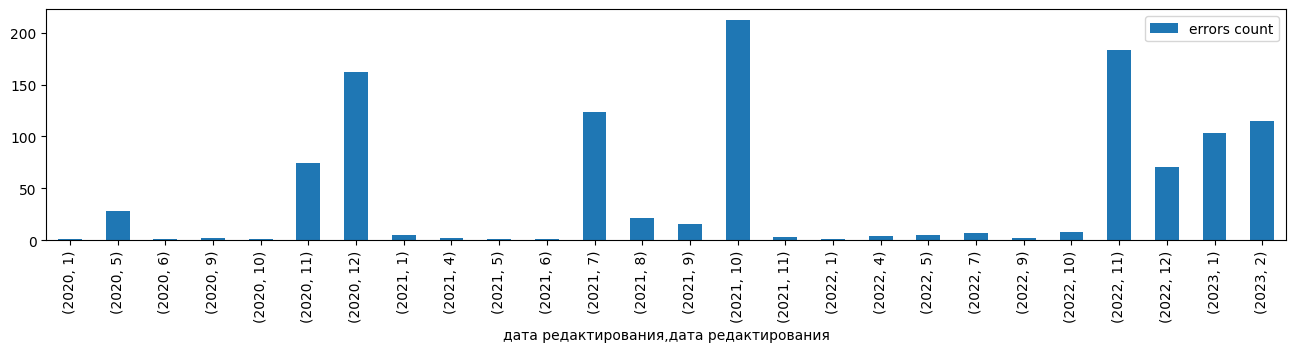

In [74]:
# userdocs.groupby(userdocs["дата редактирования"].dt.year, userdocs["дата редактирования"].dt.month) [['errors count','дата редактирования']] .count().plot(kind="bar")
import matplotlib.pyplot as plt


ax = userdocs.groupby(
    [userdocs["дата редактирования"].dt.year, userdocs["дата редактирования"].dt.month ])[
        ['errors count']].count().plot(kind="bar", figsize=(16,3))

plt.show()

In [75]:
userdocsBak = userdocs.copy()

In [76]:
from collections import Counter


l = list(userdocs['vat_unit'].values) + list( userdocs['currency'].values)
l= [str(k).lower() for k in l]
c = Counter(l)
rare_currency=[]
for k in c:
    if c[k] < 2:
        rare_currency.append(k)
        

l = list(userdocs['Псевдоним 1'].values) + list( userdocs['Псевдоним 2'].values)
l= [str(k).lower() for k in l]
c = Counter(l)
rare_aliases=[]
for k in c:
    if c[k] < 2:
        rare_aliases.append(k)
# rare_aliases


l = list(userdocs['Форма собственности 1'].values) + list( userdocs['Форма собственности 2'].values)
l= [str(k).lower() for k in l]
c = Counter(l)
rare_forms=[]
for k in c:
    if c[k] < 2:
        rare_forms.append(k)
# print(rare_forms)        
        
    
    
for i, row in userdocs.iterrows():
    fs1 = str(row['Форма собственности 1']).lower()
    fs2 = str(row['Форма собственности 2']).lower()
    
    as1 = str(row['Псевдоним 1']).lower()
    as2 = str(row['Псевдоним 2']).lower()
    
    
    cs1 = str(row['vat_unit']).lower()
    if cs1 in rare_currency:
        print(i, f'[{cs1}]')
        add_error(userdocs, i, "Валюта налога очень странная" )
        
    cs2 = str(row['currency']).lower()
    if cs2 in rare_currency:
        print(i, f'[{cs2}]')
        add_error(userdocs, i, "Валюта очень странная" )
    
    if fs1 in rare_forms:
        print(i, f'[{fs1}]')
        add_error(userdocs, i, "Форма собственности 1 очень странная" )
    if fs2 in rare_forms:
        print(i, f'[{fs2}]')
        add_error(userdocs, i, "Форма собственности 2 очень странная" )
        
    if as1 in rare_aliases:
        print(i, f'[{as1}]')
        add_error(userdocs, i, "Псевдоним 1 очень странный" )
    if as2 in rare_aliases:
        print(i, f'[{as2}]')
        add_error(userdocs, i, "Псевдоним 2 очень странный" )
        
userdocs

5fbbbd13a2b4551c061078bf [%]
5fbbbd13a2b4551c061078bf [рублей]
5fbbbd13a2b4551c061078bf [страхователь]
5fbbbd13a2b4551c061078bf [страховщик]


,дата редактирования,link,error,error missing,errors count,subject len,subject kind,Форма собственности 1,Наименование 1,Псевдоним 1,...,Дата,сумма,сумма (старая),currency,Номер,сумма без налога,сумма с налогом,налог,vat_unit,subject
6152e3af8558145da68d8790,2023-02-01 14:53:58.672,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,налог не указан;\nНомер не является номером;\n,Наименование 2 отсутсвует;\nФорма собственност...,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6152e3798558145da68d8788,2021-09-30 08:13:06.705,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,,Псевдоним 2 отсутсвует;\nНаименование 2 отсутс...,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6285f525f098f73e14297f93,2022-10-25 11:16:59.890,https://gpn-audit.nemosoft.ru/#/audit/edit/628...,Наименование 2: кавычка не закрыта;\nНаименова...,Форма собственности 2 отсутсвует;\nФорма собст...,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615ac8b28f3b0514f3f423f2,2021-10-04 09:27:25.636,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,,Псевдоним 2 отсутсвует;\nФорма собственности 2...,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615ac8cf8f3b0514f3f423f8,2021-10-04 09:30:37.752,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,Номер не является номером;\n,Псевдоним 2 отсутсвует;\nПсевдоним 1 отсутсвуе...,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638085a86a07f3e980b2c6b5,2022-11-29 14:14:04.008,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,,,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638085a86a07f3e980b2c6b2,2022-11-29 09:53:35.014,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,,,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638085a86a07f3e980b2c6b1,2022-11-29 09:14:42.946,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,,,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638085a86a07f3e980b2c6ae,2022-11-29 11:04:08.406,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,,,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:

userdocs=userdocs.sort_values(["errors count"], ascending=False)
userdocs.to_csv("errors.csv", index=True)     
# userdocs



In [78]:
userdocs_subj = userdocs[ ['subject kind', 'Псевдоним 1', 'Псевдоним 2']]
# userdocs_subj

def get_alias_pair(v):
    return ' -vs- '.join(   np.sort( list([ str(v['Псевдоним 1']).lower(), str(v['Псевдоним 2']).lower()])) ) 


 
c=Counter([get_alias_pair(v) for i, v in userdocs_subj.iterrows()])
rare_aliases_pairs=[k for k in c if c[k] < 2]
for i, row in userdocs.iterrows():
    d=get_alias_pair(row)
    if d in rare_aliases_pairs:
        print(i, f'[{d}]')
        userdocs.at[i, 'strange alias combo'] =f"Необычная пара псевдонимов: {d}"
        
print('-'*20)
del rare_aliases_pairs
# # rare_aliases_pairs
        
# del d
    
def get_alias_subject_pair(v, i):
    return ' / '.join(    list([ str(v[f'Псевдоним {i}']).lower(), str(v['subject kind']).lower()])) 
    
p1 = [get_alias_subject_pair(v, 1) for i, v in userdocs_subj.iterrows()]


c=Counter(p1+[get_alias_subject_pair(v, 2) for i, v in userdocs_subj.iterrows()])
rare_alias_subj_pairs=[k for k in c if c[k] < 3]

for i, row in userdocs.iterrows():
    d1 = get_alias_subject_pair(row, 1)
    d2 = get_alias_subject_pair(row, 2)
    
    if d1 in rare_alias_subj_pairs:
        print(i, f'[{d1}]')
        userdocs.at[i, 'strange alias-subject'] =f"Необычная пара псевдоним-предмет: {d1}"
    
    if d2 in rare_alias_subj_pairs :
        print(i, f'[{d2}]')
        userdocs.at[i, 'strange alias-subject'] =f"Необычная пара псевдоним-предмет: {d2}"
        
print('-'*20)        
rare_alias_subj_pairs


5fbbbd13a2b4551c061078bf [страхователь -vs- страховщик]
--------------------
5fbbbd13a2b4551c061078bf [страхователь / none]
5fbbbd13a2b4551c061078bf [страховщик / none]
--------------------


['страхователь / none', 'страховщик / none']

In [79]:
_s = f"#### {datetime.today().strftime('%d.%m.%Y')} *Всего* ошибок, недочетов и проч.: {userdocs['errors count'].sum()} в {len(userdocs)} документах -- ({userdocs['errors count'].sum()/len(userdocs):0.2f} на документ)"
display(Markdown(_s))

#### 08.02.2023 *Всего* ошибок, недочетов и проч.: 1284.0 в 1153 документах -- (1.11 на документ)

In [80]:
userdocs_subj = userdocs[ ['link','subject kind', 'Псевдоним 1', 'Псевдоним 2', 'strange alias combo', 'strange alias-subject' ]]

errors_subjects = userdocs_subj[userdocs_subj['strange alias combo'].notnull() | userdocs_subj['strange alias-subject'].notnull() ]
errors_subjects.to_csv("errors_subjects.csv", index=True)         
errors_subjects

,link,subject kind,Псевдоним 1,Псевдоним 2,strange alias combo,strange alias-subject
5fbbbd13a2b4551c061078bf,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,None,Страхователь,Страховщик,Необычная пара псевдонимов: страхователь -vs- ...,Необычная пара псевдоним-предмет: страховщик /...


In [81]:
userdocs[userdocs['errors count']<2]

,дата редактирования,link,error,error missing,errors count,subject len,subject kind,Форма собственности 1,Наименование 1,Псевдоним 1,...,сумма (старая),currency,Номер,сумма без налога,сумма с налогом,налог,vat_unit,subject,strange alias combo,strange alias-subject
5fbbe468a2b4551c06107b2a,2020-11-24 07:39:25.224,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,Наименование 1: кавычка не закрыта;\n,,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5ec2b8d9665f7603e03b1238,2021-10-26 19:24:52.024,https://gpn-audit.nemosoft.ru/#/audit/edit/5ec...,налог не указан;\n,,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5fbbe467a2b4551c06107b08,2020-11-24 07:46:22.030,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,налог не указан;\n,,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5fca2ab09083b679224c7626,2021-07-30 10:16:56.228,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,налог не указан;\n,,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5ec2b8d9665f7603e03b1243,2020-05-21 16:42:06.165,https://gpn-audit.nemosoft.ru/#/audit/edit/5ec...,"сумма договора слишком короткая: 7 слов, нужно...",,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628603754d1bfe5e5b297dea,2023-02-02 10:16:56.372,https://gpn-audit.nemosoft.ru/#/audit/edit/628...,,,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5fc63d611d0a1603c7a0c97d,2020-12-18 07:42:51.215,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,,,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6393256f1002115a6029f3f0,2023-02-04 08:05:50.469,https://gpn-audit.nemosoft.ru/#/audit/edit/639...,,,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
636cb443f67f84810526f916,2023-02-08 10:57:19.267,https://gpn-audit.nemosoft.ru/#/audit/edit/636...,,,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Make datapoints

In [115]:
work_dir

PosixPath('/root/artem/work')

In [116]:
from analyser.headers_detector import get_tokens_features
from tf_support.embedder_elmo import ElmoEmbedder
from analyser.legal_docs import embedd_tokens
import os

embedder = ElmoEmbedder.get_instance('elmo')  # lazy init

def _dp_fn(doc_id, suffix):
    return os.path.join(work_dir, 'datasets', f'{doc_id}-datapoint-{suffix}.npy')


def save_contract_data_arrays(db_json_doc: DbJsonDoc):
    # TODO: trim long documens according to contract parser

    id_ = db_json_doc.get_id()

    tokens_map: TextMap = db_json_doc.get_tokens_for_embedding()

    # 1) EMBEDDINGS
    print(len(tokens_map))
    embeddings = embedd_tokens(tokens_map,
                               embedder,
                               log_key=f'id={id_} chs={tokens_map.get_checksum()}')

    # 2) TOKEN FEATURES
    token_features: DataFrame = get_tokens_features(db_json_doc.get_tokens_map_unchaged().tokens)

    # 3) SEMANTIC MAP
    semantic_map: DataFrame = get_semantic_map_new(db_json_doc)
    #####
 
    np.save(_dp_fn(id_, 'token_features'), token_features)
    np.save(_dp_fn(id_, 'semantic_map'), semantic_map)
    _embeddings_file = _dp_fn(id_, 'embeddings')
    np.save(_embeddings_file, embeddings)
    print(f'embeddings saved to {_embeddings_file} {embeddings.shape}')

In [117]:
_docs_ids = [str(i) for i in new_docs_ids]
intersection_set = set.intersection(set(list(dups_s.index)), set(_docs_ids)) 
len(intersection_set)
# intersection_set




80

### Trainset fixtures
#### Invalidate long subjects

In [118]:
ids = list(dups_s.index)


ids_of_long_subject_docs=[]

for k, oid in enumerate(ids):

    _id = str(oid)
    iiid= ObjectId(_id)
    
    src = dups_s.loc[_id]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state not in [15,12]:
                print(jd.state, iiid)
            
            stats.at[_id, 'documentType'] = jd.documentType
            dups_s.at[_id, 'documentType'] = jd.documentType
            
            attr_tree = jd.get_attributes_tree()  
            span = attr_tree.get('subject', {}).get('span',[0,0])
            subject_len = span[1]-span[0]
            stats.at[_id, 'subj_len'] = subject_len
            dups_s.at[_id, 'subj_len'] = subject_len            
                
            if span[0]==0:
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
            if subject_len >= 200:
                
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
                
                
                ids_of_long_subject_docs.append(oid)
                
                tm = jd.get_tokens_map_unchaged()
                quote = tm.text_range(span)
                print(k, iiid, span, span[1]-span[0])
#                 print('-'*100)
                sentence_span = tm.sentence_at_index(span[0])
                quote2 = tm.text_range(sentence_span)
                print(quote2[:50])
                print('='*100)
stats[stats['documentType']=='CONTRACT']

dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)

/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


3008 63ce4a28e83d1ee490f3f4b2 [0, 200] 200
ПРИЛОЖЕНИЕ № 4 К КОНТРАКТУ № от ANNEX No. 4. и TO 
3042 63ce4a83e83d1ee490f3f9eb [0, 200] 200
Приложение № 7 к договору № от" "2019 года

3063 63ce4b0ee83d1ee490f400d1 [0, 200] 200
Приложение № 1 от 29-04-2021 год.



#### Fix missing headers

In [119]:
from analyser.legal_docs import LegalDocument, PARAGRAPH_DELIMITER, GenericDocument, Paragraph
from analyser.ml_tools import SemanticTag
from integration.word_document_parser import join_paragraphs


def save_analysis(db_document: DbJsonDoc, doc_dummie: LegalDocument) -> DbJsonDoc:
  documents_collection = get_mongodb_connection()['documents']
  
  _analyse_json_obj: dict = doc_dummie.to_json_obj()
  print("--analyse_json_obj['headers'] len=", len(_analyse_json_obj['headers']))

#   to_save = db_document.as_dict()
#   to_save['headers'] = _analyse_json_obj['headers']

  documents_collection.update_one({'_id': doc_dummie.get_id()}, {'$set': {'analysis.headers': _analyse_json_obj['headers']}})
 
    
  print("updated", doc_dummie.get_id())


def restore_headers (response, oid) :
  doc = join_paragraphs(response, oid)
  return doc
   


def restore_headlines(k,oid):    

    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state in [15,12]:
                if len(jd.analysis.get('headers', [])) > 0:
                    #  all is ok
#                     print(oid)
                    pass
                else:
                     doc_with_paragraphs = restore_headers(jd.parse, iiid)
                     save_analysis(jd,  doc_with_paragraphs)
                     print ('--', k, oid, len(doc_with_paragraphs.paragraphs))

                    
for k, oid in enumerate(ids):
    restore_headlines(k,oid)


In [120]:
# restore_headlines(1,'62d149474ae369b4976e31fc'): 

In [121]:
len(ids_of_long_subject_docs)

3

In [122]:
dups_s

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,user_correction_date,valid,documentType,subj_len,headers,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
6340244c9d08c565cfa12341,db,bc7d70a32aed6af4ef6c7752a1b7674d,3.0.0,2023-01-31 18:37:33.526517,6740.0,2022-10-07 16:09:15.340000+00:00,2.000000e+09,21.416413,909.0,RUB,...,2022-10-07 13:43:21.470000+00:00,True,AGREEMENT,130.0,22.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6340...,False,3.545353e-01,8.475038e+18,1.0
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-01 17:26:52.044394,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,2023-01-27 10:27:22.086000+00:00,True,CONTRACT,79.0,4.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,6.465962e-01,1.600482e+18,1.0
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-02-05 13:09:05.381133,1370.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,2020-07-18 12:24:26.280000+00:00,True,CONTRACT,106.0,10.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,6.507901e-01,4.237525e+18,1.0
5ded4e284ddc27bcf92dd6ce,file,9a44591c17d2b8f34dc8f1c3600c8c3a,1.11.2,2023-02-05 13:09:01.777643,460.0,2020-06-12 21:09:19.574000+00:00,5.900000e+05,13.287880,150.0,RUB,...,2020-06-09 00:40:54.752000+00:00,True,CONTRACT,30.0,5.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,False,7.597030e-01,5.651422e+18,1.0
63ce49f8e83d1ee490f3f21c,db,25d924fc09b7291d964f464f9c3ec8c3,23.1.27.1,2023-02-03 16:19:06.576376,8530.0,2023-01-28 09:34:50.691000+00:00,3.000000e+09,21.821878,337.0,RUB,...,2023-01-28 01:38:49.198000+00:00,True,CONTRACT,53.0,12.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,False,1.155858e+00,-4.871516e+18,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fb2796dd8c9df1ed1236da1,db,b733e0ee7d949178ac45254c1d20318b,2.4.4,2023-01-31 18:37:43.648610,130.0,2021-07-23 10:20:47.637000+00:00,NaN,NaN,NaN,NaN,...,NaT,False,ANNEX,0.0,2.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb2...,True,1.440000e+08,8.008172e+18,10.0
5fb376e7d8c9df1ed1237344,db,3d0fea955ac3bd7a07c96d0f68a8b491,2.5.3,2023-01-31 18:37:59.243967,210.0,2021-10-28 15:52:29.224000+00:00,NaN,NaN,NaN,NaN,...,NaT,False,ANNEX,0.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,1.440000e+08,1.596129e+18,11.0
5fb27c60d8c9df1ed1236ebb,db,a77061e7f6ae850a1c5b0f2d12b9fff3,2.4.4,2023-01-31 18:37:43.782338,120.0,2021-07-23 10:32:28.793000+00:00,NaN,NaN,NaN,NaN,...,NaT,False,ANNEX,0.0,2.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb2...,True,1.440000e+08,-5.591959e+18,21.0


In [123]:
stats.to_csv(export_fn, index=True)

In [ ]:


for k, oid in enumerate(ids):
    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
          jd = DbJsonDoc(d)
    else:
#         if False:
        print(oid, k, 'of', len(ids), src)
        jd = files_dict[iiid]
        
    print(oid, k, 'of', len(ids), src)

    if jd is not None:
        if jd.state in [15,12]:                
            save_contract_data_arrays(jd)


In [ ]:
25